# Capstone Project - The Battle of Neighbourhoods 
# Housing Sales Prices & Venues Data Analysis of Barcelona



## 1. Introduction

This article is the main part of a Capstone Project in order to obtain the IBM Data Science Professional Certificate, where the main task is use data science techniques to compare neighbourhoods or cities of our choice or to come up with a problem where Foursquare location data can be used to solve it.<br>
<br>
I have chosen to analyse the neighbourhoods of Barcelona which is the city where I currently live in. With a population of 1.6 million within city limits in an area of only 102.2 Km2, Barcelona is one of the most densely populated cities in Europe. The city is divided into 10 districts and there is also a new second-level administrative division of 73 neighbourhoods that was approved in 2006. This subdivision in neighbourhoods is what I am going to use in this research project.<br>
<br>
When we think about city residents, they prefer to choose areas with lower real estate prices but at the same time they consider the venues, services and other commercial activity that are present in them. The aim of this study is to group similar neighbourhoods in terms of the density of venues and premises that are present on the area. If one specific city resident likes a specific type of neighbourhood because he likes the venues category that are on it, he could also look for other neighbourhoods that belong to the same cluster and have lower prices. <br>
<br>
Another target audience of this research are investors that pretend to create a business, as they may want to select neighbourhoods where the business activity in which they want to invest is less intense and also detect unattended areas.
Finally, this study might give some insights about factors that influence in the real estate prices, which may be useful for real estate agents. We will study if clusters with a similar density of venues and commercial premises tend to have the same price in Barcelona, or on the contrary they are not a determinant factor for the price. <br>
<br>
A significant factor that helps in this research is the fact that Barcelona has long been a leader in the movement of smart cities and it is part of a select group of pioneers in smart urban planning along with cities such as Singapore, Vienna, San Francisco and Copenhagen. As a result, it is very effective in collecting a huge amount of data and most of it is available for free to general public. About most than 400 datasets are available in Barcelona's City Hall Open Data Service (https://opendata-ajuntament.barcelona.cat/en/), including information about venues located on each neighbourhood and purchase housing prices. In addition to this, cartographic data about administrative divisions is available for free in the cartographic division of Barcelona City Hall CartoBCN.<br>


## 2. Data

### 2.1 Sources used in the project

The following sources has been used to carry out the project: <br>
- a) ED50 Administrative Divisions in 2010 from Carto BCN. Contains the code, description and geopraphical position of the center and the shape of each city neoghbouurhood and district. It is possible to download the information by creating a free account. This file will be used to get the geopraphical center of each neoghbourhood and also their boundaries to create maps. https://w20.bcn.cat/cartobcn/ <br>
<br>
- b) Purchase of registered properties of the city of Barcelona in 2018. Information about housing prices per square meter. Information will be used to detect correlations between neighbourhoods cluster ans average housing prices. https://opendata-ajuntament.barcelona.cat/data/en/dataset/est-mercat-immobiliari-compravenda-preu-total<br>
<br>
- c) Venues around a certain location by using a Foursquare API <br>
<br>
- d) Inventory of premises of the city of Barcelona. This it will be used to contrast results obtained by using Foursquare data. https://opendata-ajuntament.barcelona.cat/data/en/dataset/cens-activitats-comercials <br>


### 2.2 Analyze and visualiza data for the analysis

#### Import libraries

We import all the libraries that are going to be used in the whole notebook

In [3]:
import pandas as pd
import numpy as np

#!conda install -c conda-forge pyshp --yes
import shapefile #provides support to handle ESRI Shapefiles in pure Python.

#!conda install -c conda-forge utm --yes
import utm #allows to convert geospatial coordinates from UTM to GPS format

from json import dumps
#!conda install -c conda-forge unidecode --yes
import unidecode

#!conda install -c conda-forge folium=0.5.0 --yes
import folium

import requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans 
from sklearn import metrics
from scipy.spatial.distance import cdist

#### a) Administrative Divisions in 2010 from Carto BCN

Instead of using a post code approach, we have decided to use data from cartographic department of Barcelona Town Council with information of districts and neoghbourhoods, their shapes and boundaries. They can be downloaded for free from https://w20.bcn.cat/cartobcn/default.aspx?lang=en by creating a free account in ESRI format.<br>
<br>
ESRI format contains a shapefile (shp) which contains the shapes in vectorial format of the different neighbourhoods and districs of the city, and a database file (dfx) which contain some statistical data of every neighbourhood. They can be easily read with the Python library pyshp (https://pypi.org/project/pyshp/) <br>
<br>
The database contains the following fields: <br>
o District: District code  <br>
o NDistric: District name  <br>
o CBarri: Neighbourhood code  <br>
o NBarri: neighbourhood name  <br>
o Homes: Number of men  <br>
o Dones: Number of women. <br>
o Perimetr: Perimiter <br>
o Area: Surface in square meters  <br>
o Coord_X: X-axis centroid coordinates, in UTM format<br>
o Coord_Y: Y-axis centroid coordinates, in UTM format<br>
o Web1: Link to district's web page  <br>
o Web2: Link to city's annual stats  <br>
o Web3: Link to districts's annual stats  <br>
o Web4: Link to neoighboourhood's annual stats  <br>
<br>
A shapefile file with vectorial information of neighbourhood boundaries will be used to create city maps with Cloropeth library and Coord_X and Coord_Y files, as they define of the centroid of each neighbourhood, will be used to make queries with Foursquare API. However downloaded data use UTM format, and we need to convert it to GPS coordenates. Therefore we are going to transform the files.

Define define input and ouput filename parameters

In [2]:
raw_neighbourhood_file = 'raw_data/BCN_Barri_ED50_SHP'
processed_neighbourhood_file = 'processed_data/BCN_Barri_ED50_SHP'    
processed_neighbourhood_jsonfile = 'processed_data/BCN_Barri_ED50_SHP.json'    

In [3]:
#Using PyShp create a Reader object to access the data from the Barcelona Shapefile                
shp_r = shapefile.Reader(raw_neighbourhood_file)
shp_r.shapeType

5

In [4]:
#Create a Writer object to write data to as a new Shapefile
shp_w = shapefile.Writer(processed_neighbourhood_file)   

Set variables for access to the field information of both the original and new Shapefile. We visualize the name of the fields in Catalan that dataset contains

In [5]:
shp_fields_r = shp_r.fields
shp_fields_w = shp_w.fields
shp_fields_r 

[('DeletionFlag', 'C', 1, 0),
 ['C_Distri', 'C', 2, 0],
 ['N_Distri', 'C', 75, 0],
 ['C_Barri', 'C', 2, 0],
 ['N_Barri', 'C', 50, 0],
 ['Homes', 'N', 9, 0],
 ['Dones', 'N', 9, 0],
 ['Area', 'F', 19, 11],
 ['Perim', 'F', 19, 11],
 ['Coord_X', 'F', 19, 11],
 ['Coord_Y', 'F', 19, 11],
 ['WEB_1', 'C', 75, 0],
 ['WEB_2', 'C', 75, 0],
 ['WEB_3', 'C', 75, 0],
 ['WEB_4', 'C', 75, 0]]

We replicate the field structure from the original into the new. However, we will use this step to translate variable names to English and also change coords for GPS longitude and latitude. The ‘Deletion Flag’ as set in the Shapefile standard will be passed over (the tuple in the if statement).

In [6]:
for name in shp_fields_r:
    if type(name) == "tuple":
        continue
    elif name[0] == "C_Distri":
        args = name
        args[0] = 'C_Dist'
        shp_w.field(*args)
    elif name[0] == "N_Distri":
        args = name
        args[0] = 'N_Dist'
        shp_w.field(*args)
    elif name[0] == "C_Barri":
        args = name
        args[0] = 'C_Neigh'
        shp_w.field(*args)
    elif name[0] == "N_Barri":
        args = name
        args[0] = 'N_Neigh'
        shp_w.field(*args)
    elif name[0] == "Homes":
        args = name
        args[0] = 'Men' 
        shp_w.field(*args)
    elif name[0] == "Dones":
        args = name
        args[0] = 'Women' 
        shp_w.field(*args)
    elif name[0] == "Perim":
        args = name
        args[0] = 'Perimeter' 
        shp_w.field(*args)
    elif name[0] == "Coord_X":
        args = ['Longitude', 'F', 8, 16]
        shp_w.field(*args)
    elif name[0] == "Coord_Y":
        args = ['Latitude', 'F', 8, 16]     
        shp_w.field(*args)
    else:
        args = name
        shp_w.field(*args)
        
shp_w.fields

[('DeletionFlag', 'C', 1, 0),
 ('C_Dist', 'C', 2, 0),
 ('N_Dist', 'C', 75, 0),
 ('C_Neigh', 'C', 2, 0),
 ('N_Neigh', 'C', 50, 0),
 ('Men', 'N', 9, 0),
 ('Women', 'N', 9, 0),
 ('Area', 'F', 19, 11),
 ('Perimeter', 'F', 19, 11),
 ('Longitude', 'F', 8, 16),
 ('Latitude', 'F', 8, 16),
 ('WEB_1', 'C', 75, 0),
 ('WEB_2', 'C', 75, 0),
 ('WEB_3', 'C', 75, 0),
 ('WEB_4', 'C', 75, 0)]

Now we want to populate the fields with attribute information. In order to achive this, we create a variable to access the records of the original file.

In [7]:
shp_r.encoding = 'Latin-1' #Encoding for Western languages such as Catalan
records = shp_r.records()

In [8]:
records[0:4]

[Record #0: ['01', 'Ciutat Vella', '01', 'el Raval', 26553, 21850, 1098392.91379, 5557.3728782, 430732.006258, 4581363.15123, 'http://www.bcn.cat/ciutatvella', 'http://www.bcn.cat/estadistica/catala/dades/inf/anuari/index.htm', 'http://www.bcn.cat/estadistica/catala/dades/guiadt01/index.htm', 'http://www.bcn.cat/estadistica/catala/dades/inf/barris/a2011/barri1.pdf'],
 Record #1: ['01', 'Ciutat Vella', '02', 'el Barri Gòtic', 8368, 7508, 841905.077496, 5683.00485624, 431315.817811, 4581594.76566, 'http://www.bcn.cat/ciutatvella', 'http://www.bcn.cat/estadistica/catala/dades/inf/anuari/index.htm', 'http://www.bcn.cat/estadistica/catala/dades/guiadt01/index.htm', 'http://www.bcn.cat/estadistica/catala/dades/inf/barris/a2011/barri2.pdf'],
 Record #2: ['01', 'Ciutat Vella', '03', 'la Barceloneta', 7581, 7631, 1313867.98294, 13039.2667933, 432374.695771, 4581152.20728, 'http://www.bcn.cat/ciutatvella', 'http://www.bcn.cat/estadistica/catala/dades/inf/anuari/index.htm', 'http://www.bcn.cat/es

Copy the records from the original into the new. However, we are going to transform coordinates of the centroid from UTM format to GPS format. In this case it is needed to provide the UTM zone. In the case of Barcelona UTM zone is 31T. See more information in https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system .UTM library is used to carry out the transformation of coordinates.<br>
<br>
We will also use unicode libraty to remove accents and some special characters of Catalan language.

In [9]:
for row in records:
    args = row
    args[1] = str.title(unidecode.unidecode(args[1]))
    args[3] = str.title(unidecode.unidecode(args[3]))
    args[9],args[8] = utm.to_latlon(args[8], args[9], 31, 'T')
    shp_w.record(*args)

We need to access the geometry of the features in the original file so give yourself access to it.

In [10]:
geom = shp_r.shapes()

Now we loop through each feature in the original dataset, access every point that makes up the geometry, convert the coordinates for each point and re-assemble transformed geometry in the new Shapefile. The if statement will handle geometry with only one part making up the feature.

In [11]:
#This code is an adaption of how to reproject a Polygon Shapefile using PyShp 
#(https://glenbambrick.com/2016/01/24/reproject-shapefile/)
#but instead of using PyProj library we have used instead UTM libraty to transform coordinates

for feature in geom:
    # if there is only one part
    if len(feature.parts) == 1:
        # create empty list to store all the coordinates
        poly_list = []
        # get each coord that makes up the polygon
        for coords in feature.points:
            x, y = coords[0], coords[1]
            # tranform the coord
            #new_x, new_y = transform(input_projection, output_projection, x, y)
            new_y, new_x = utm.to_latlon(x, y, 31, 'T')
            # put the coord into a list structure
            poly_coord = (float(new_x), float(new_y))
            # append the coords to the polygon list
            poly_list.append(poly_coord)     
        # add the geometry to the shapefile.
        shp_w.poly([poly_list])
    else:
        # append the total amount of points to the end of the parts list
        feature.parts.append(len(feature.points))
        # enpty list to store all the parts that make up the complete feature
        poly_list = []
        # keep track of the part being added
        parts_counter = 0

        # while the parts_counter is less than the amount of parts
        while parts_counter < len(feature.parts) - 1:
            # keep track of the amount of points added to the feature
            coord_count = feature.parts[parts_counter]
            # number of points in each part
            no_of_points = abs(feature.parts[parts_counter] - feature.parts[parts_counter + 1])
            # create list to hold individual parts - these get added to poly_list[]
            part_list = []
            # cut off point for each part
            end_point = coord_count + no_of_points

            # loop through each part
            while coord_count < end_point:
                for coords in feature.points[coord_count:end_point]:
                    x, y = coords[0], coords[1]
                    # tranform the coord
                    #new_x, new_y = transform(input_projection, output_projection, x, y)
                    new_y, new_x = utm.to_latlon(x, y, 31, 'T')
                    # put the coord into a list structure
                    poly_coord = [float(new_x), float(new_y)]
                    # append the coords to the part list
                    part_list.append(poly_coord)
                    coord_count = coord_count + 1
            # append the part to the poly_list
            poly_list.append(part_list)
            parts_counter = parts_counter + 1
        # add the geometry to to new file
        shp_w.poly(poly_list)

We save the processed file

In [12]:
shp_w.close()

We create a processed GeoJSON file which it is going to be used to create map plots with Chloropeth library later

In [13]:
# read the shapefile
reader = shapefile.Reader(processed_neighbourhood_file)
fields = reader.fields[1:]
field_names = [field[0] for field in fields]
buffer = []
for sr in reader.shapeRecords():
    atr = dict(zip(field_names, sr.record))
    geom = sr.shape.__geo_interface__
    buffer.append(dict(type="Feature", \
    properties=atr, geometry=geom)) 

# write the GeoJSON file
geojson = open(processed_neighbourhood_jsonfile, "w")
geojson.write(dumps({"type": "FeatureCollection",\
"features": buffer}, indent=2) + "\n")
geojson.close()

Now we can load preprocessed neighbourhood file into a dataframe

In [14]:
#read file, parse out the records and shapes
shp_r = shapefile.Reader(processed_neighbourhood_file)
shp_r.encoding = 'Latin-1'

#grab the shapefile's field names (omit the first psuedo field)
fields = [x[0] for x in shp_r.fields][1:]
#records = sf.records()
records = [r[:] for r in shp_r.records()]
shps = [s.points for s in shp_r.shapes()]

#write the records into a dataframe
bcn_neigh_df = pd.DataFrame(columns=fields, data=records)

#add the coordinate data to a column called "coords"
bcn_neigh_df = bcn_neigh_df.assign(coords=shps)



Visualize the processed file with longitude and latitude information of each neighbourhood in the city. Fields that are going to be used of this processed file are: <br>
- C_Neigh: Neighbourhood code <br>
- N_Neigh: Neighbourhood name <br>
- Longitude:- GPS Longitude of the neighbourhood centroid <br>
- Latitude: GPS Latitude of the neighbourhood centroid <br>

In [15]:
bcn_neigh_df.head(15)

C_Dist          N_Dist C_Neigh                                N_Neigh  \
0      01    Ciutat Vella      01                               El Raval   
1      01    Ciutat Vella      02                         El Barri Gotic   
2      01    Ciutat Vella      03                         La Barceloneta   
3      01    Ciutat Vella      04  Sant Pere, Santa Caterina I La Ribera   
4      02        Eixample      05                          El Fort Pienc   
5      02        Eixample      06                     La Sagrada Familia   
6      02        Eixample      07                 La Dreta De L'Eixample   
7      02        Eixample      08        L'Antiga Esquerra De L'Eixample   
8      02        Eixample      09         La Nova Esquerra De L'Eixample   
9      02        Eixample      10                            Sant Antoni   
10     03  Sants-Montjuic      11                           El Poble Sec   
11     03  Sants-Montjuic      12             La Marina Del Prat Vermell   
12     03  Sants-Montjuic      13                      La Marina De Port   
13     03  Sants-Montjuic      14                  La Font De La Guatlla   
14     03  Sants-Montjuic      15                            Hostafrancs   

      Men  Women          Area     Perimeter  Longitude  Latitude  \
0   26553  21850  1.098393e+06   5557.372878   2.171593  41.38081   
1    8368   7508  8.419051e+05   5683.004856   2.178549  41.38294   
2    7581   7631  1.313868e+06  13039.266793   2.191261  41.37905   
3   11466  11390  1.114299e+06   4658.031512   2.184539  41.38864   
4   15039  16924  9.289010e+05   4175.971325   2.182589  41.39926   
5   23686  27937  1.050991e+06   4336.621674   2.177686  41.40729   
6   20240  23754  2.123405e+06   6460.307377   2.169300  41.39573   
7   19434  22727  1.234453e+06   4851.622805   2.156252  41.39120   
8   27038  31186  1.337656e+06   4626.630284   2.150079  41.38490   
9   18134  20378  8.009851e+05   4711.253241   2.160452  41.38038   
10  20213  20693  4.604541e+06   9956.448009   2.159350  41.36726   
11    577    561  1.428413e+07  43242.508489   2.143704  41.34118   
12  14728  15751  1.254642e+06   5818.641275   2.140942  41.36181   
13   4936   5545  3.020617e+05   2867.615611   2.145947  41.37159   
14   7670   8284  4.102060e+05   3138.021123   2.145344  41.37716   

                                WEB_1  \
0      http://www.bcn.cat/ciutatvella   
1      http://www.bcn.cat/ciutatvella   
2      http://www.bcn.cat/ciutatvella   
3      http://www.bcn.cat/ciutatvella   
4         http://www.bcn.cat/eixample   
5         http://www.bcn.cat/eixample   
6         http://www.bcn.cat/eixample   
7         http://www.bcn.cat/eixample   
8         http://www.bcn.cat/eixample   
9         http://www.bcn.cat/eixample   
10  http://www.bcn.cat/sants-montjuic   
11  http://www.bcn.cat/sants-montjuic   
12  http://www.bcn.cat/sants-montjuic   
13  http://www.bcn.cat/sants-montjuic   
14  http://www.bcn.cat/sants-montjuic   

                                                WEB_2  \
0   http://www.bcn.cat/estadistica/catala/dades/in...   
1   http://www.bcn.cat/estadistica/catala/dades/in...   
2   http://www.bcn.cat/estadistica/catala/dades/in...   
3   http://www.bcn.cat/estadistica/catala/dades/in...   
4   http://www.bcn.cat/estadistica/catala/dades/in...   
5   http://www.bcn.cat/estadistica/catala/dades/in...   
6   http://www.bcn.cat/estadistica/catala/dades/in...   
7   http://www.bcn.cat/estadistica/catala/dades/in...   
8   http://www.bcn.cat/estadistica/catala/dades/in...   
9   http://www.bcn.cat/estadistica/catala/dades/in...   
10  http://www.bcn.cat/estadistica/catala/dades/in...   
11  http://www.bcn.cat/estadistica/catala/dades/in...   
12  http://www.bcn.cat/estadistica/catala/dades/in...   
13  http://www.bcn.cat/estadistica/catala/dades/in...   
14  http://www.bcn.cat/estadistica/catala/dades/in...   

                                                WEB_3  \
0   http://www.bcn.cat/estadistica/catala/dades/gu... 

In [16]:
bcn_neigh_df[['C_Neigh','N_Neigh','Longitude', 'Latitude','coords']].head(10)

C_Neigh                                N_Neigh  Longitude  Latitude  \
0      01                               El Raval   2.171593  41.38081   
1      02                         El Barri Gotic   2.178549  41.38294   
2      03                         La Barceloneta   2.191261  41.37905   
3      04  Sant Pere, Santa Caterina I La Ribera   2.184539  41.38864   
4      05                          El Fort Pienc   2.182589  41.39926   
5      06                     La Sagrada Familia   2.177686  41.40729   
6      07                 La Dreta De L'Eixample   2.169300  41.39573   
7      08        L'Antiga Esquerra De L'Eixample   2.156252  41.39120   
8      09         La Nova Esquerra De L'Eixample   2.150079  41.38490   
9      10                            Sant Antoni   2.160452  41.38038   

                                              coords  
0  [(2.17114583251087, 41.387318300967955), (2.17...  
1  [(2.183565559937503, 41.38311899420626), (2.18...  
2  [(2.20082586629123, 41.38678345631065), (2.200...  
3  [(2.1834921087968935, 41.39327449798472), (2.1...  
4  [(2.1834921087968935, 41.39327449798472), (2.1...  
5  [(2.184464123030819, 41.40788069316526), (2.18...  
6  [(2.1744182656392472, 41.40183377858185), (2.1...  
7  [(2.165227982455392, 41.38815230194142), (2.16...  
8  [(2.159671850751981, 41.38397642110815), (2.15...  
9  [(2.165948853147565, 41.387764793139524), (2.1...

We can examine the neighbourhoods in a map using folium library

In [17]:
# Barcelona latitude and longitude values
latitude = 41.382894
longitude = 2.1774322

# create map and display it
bcn_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to the map
for lat, lon, poi in zip(bcn_neigh_df['Latitude'], bcn_neigh_df['Longitude'], bcn_neigh_df['N_Neigh']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=0,
        fill=True,
        fill_color=0,
        fill_opacity=0.7).add_to(bcn_map)
    
bcn_geo = processed_neighbourhood_jsonfile # geojson file
folium.Choropleth(geo_data=bcn_geo).add_to(bcn_map)

# display map
bcn_map

In [18]:
bcn_map.save('maps/bcn_neighbourhoods.html')

#### b) Housing prices 

Read CSV with housing price

In [19]:
raw_housing_price_file = 'raw_data/2018_comp_vend_preu.csv'
bcn_housing_price_df = pd.read_csv(raw_housing_price_file, dtype = {"Codi_Districte" : "str", "Codi_Barri" : "str" })
bcn_housing_price_df.head()

Any Codi_Districte Nom_Districte Codi_Barri  \
0  2018              1  Ciutat Vella          1   
1  2018              1  Ciutat Vella          2   
2  2018              1  Ciutat Vella          3   
3  2018              1  Ciutat Vella          4   
4  2018              2      Eixample          5   

                               Nom_Barri   Preu_mitja_habitatge  Valor  
0                               el Raval  Total. Milers d'euros  262.8  
1                         el Barri Gòtic  Total. Milers d'euros  541.6  
2                         la Barceloneta  Total. Milers d'euros  219.7  
3  Sant Pere, Santa Caterina i la Ribera  Total. Milers d'euros  336.9  
4                          el Fort Pienc  Total. Milers d'euros  408.1

We change column names to English

In [20]:
bcn_housing_price_df.rename(columns={"Any": "Year", "Codi_Districte": "C_Dist",  "Nom_Districte": "N_Dist", 
                                  "Codi_Barri": "C_Neigh", "Nom_Barri": "N_Neigh", "Valor": "Value", "Preu_mitja_habitatge" : "Concept"}, inplace = True)
bcn_housing_price_df['N_Neigh']  = bcn_housing_price_df['N_Neigh'].str.title()
bcn_housing_price_df.head()

Year C_Dist        N_Dist C_Neigh                                N_Neigh  \
0  2018      1  Ciutat Vella       1                               El Raval   
1  2018      1  Ciutat Vella       2                         El Barri Gòtic   
2  2018      1  Ciutat Vella       3                         La Barceloneta   
3  2018      1  Ciutat Vella       4  Sant Pere, Santa Caterina I La Ribera   
4  2018      2      Eixample       5                          El Fort Pienc   

                 Concept  Value  
0  Total. Milers d'euros  262.8  
1  Total. Milers d'euros  541.6  
2  Total. Milers d'euros  219.7  
3  Total. Milers d'euros  336.9  
4  Total. Milers d'euros  408.1

We add 0 to numerical codes with only one character in order that match with neighbourhood file

In [21]:
bcn_housing_price_df['C_Dist'].replace('1','01', inplace=True)
bcn_housing_price_df['C_Dist'].replace('2','02', inplace=True)
bcn_housing_price_df['C_Dist'].replace('3','03', inplace=True)
bcn_housing_price_df['C_Dist'].replace('4','04', inplace=True)
bcn_housing_price_df['C_Dist'].replace('5','05', inplace=True)
bcn_housing_price_df['C_Dist'].replace('6','06', inplace=True)
bcn_housing_price_df['C_Dist'].replace('7','07', inplace=True)
bcn_housing_price_df['C_Dist'].replace('8','08', inplace=True)
bcn_housing_price_df['C_Dist'].replace('9','09', inplace=True)
bcn_housing_price_df['C_Neigh'].replace('1','01', inplace=True)
bcn_housing_price_df['C_Neigh'].replace('2','02', inplace=True)
bcn_housing_price_df['C_Neigh'].replace('3','03', inplace=True)
bcn_housing_price_df['C_Neigh'].replace('4','04', inplace=True)
bcn_housing_price_df['C_Neigh'].replace('5','05', inplace=True)
bcn_housing_price_df['C_Neigh'].replace('6','06', inplace=True)
bcn_housing_price_df['C_Neigh'].replace('7','07', inplace=True)
bcn_housing_price_df['C_Neigh'].replace('8','08', inplace=True)
bcn_housing_price_df['C_Neigh'].replace('9','09', inplace=True)
bcn_housing_price_df.head()

Year C_Dist        N_Dist C_Neigh                                N_Neigh  \
0  2018     01  Ciutat Vella      01                               El Raval   
1  2018     01  Ciutat Vella      02                         El Barri Gòtic   
2  2018     01  Ciutat Vella      03                         La Barceloneta   
3  2018     01  Ciutat Vella      04  Sant Pere, Santa Caterina I La Ribera   
4  2018     02      Eixample      05                          El Fort Pienc   

                 Concept  Value  
0  Total. Milers d'euros  262.8  
1  Total. Milers d'euros  541.6  
2  Total. Milers d'euros  219.7  
3  Total. Milers d'euros  336.9  
4  Total. Milers d'euros  408.1

In [22]:
bcn_housing_price_df.groupby(['Concept', 'Year']).count()

C_Dist  N_Dist  C_Neigh  N_Neigh  Value
Concept                   Year                                         
Nou. Euros/m2 construït   2018      73      73       73       73     42
Nou. Milers d'euros       2018      73      73       73       73     42
Total. Euros/m2 construït 2018      73      73       73       73     73
Total. Milers d'euros     2018      73      73       73       73     73
Usat. Euros/m2 construït  2018      73      73       73       73     73
Usat. Milers d'euros      2018      73      73       73       73     73

We only want tha average sales price of buildings sold (Preu_mitja_habitatge = 'Total Euros/m2 construit') of last year(2018). We only want the average sales price of buildings sold (Preu_mitja_habitatge = 'Total Euros/m2 construit') of last year(2018). We are going to use the following files of this processed file: <br>
- C_Neigh: Neighbourhood code
- N_Neigh: Neighbourhood name
- AvgPricem2 - Average price (EUR/m2) of purchased real state properties

In [23]:
bcn_housing_price_df = bcn_housing_price_df[bcn_housing_price_df['Concept']=='Total. Euros/m2 construït']
bcn_housing_price_df = bcn_housing_price_df[bcn_housing_price_df['Year']==2018]
bcn_housing_price_df.rename(columns={"Value": "AvgPricem2"}, inplace = True)
bcn_housing_price_df = bcn_housing_price_df[['C_Dist', 'N_Dist', 'C_Neigh', 'N_Neigh', 'AvgPricem2']]
bcn_housing_price_df.head()

C_Dist        N_Dist C_Neigh                                N_Neigh  \
219     01  Ciutat Vella      01                               El Raval   
220     01  Ciutat Vella      02                         El Barri Gòtic   
221     01  Ciutat Vella      03                         La Barceloneta   
222     01  Ciutat Vella      04  Sant Pere, Santa Caterina I La Ribera   
223     02      Eixample      05                          El Fort Pienc   

     AvgPricem2  
219      3969.8  
220      5162.7  
221      4905.4  
222      5169.4  
223      4650.6

In [24]:
bcn_housing_price_df[['C_Neigh', 'N_Neigh', 'AvgPricem2']].head(10)

C_Neigh                                N_Neigh  AvgPricem2
219      01                               El Raval      3969.8
220      02                         El Barri Gòtic      5162.7
221      03                         La Barceloneta      4905.4
222      04  Sant Pere, Santa Caterina I La Ribera      5169.4
223      05                          El Fort Pienc      4650.6
224      06                     La Sagrada Família      3833.1
225      07                 La Dreta De L'Eixample      4436.4
226      08        L'Antiga Esquerra De L'Eixample      4503.3
227      09         La Nova Esquerra De L'Eixample      4116.8
228      10                            Sant Antoni      4140.6

#### c) Inventory of premises of the city of Barcelona.

Read CSV with the census of premises in Barcelona in 2016

In [5]:
raw_premises_file = 'raw_data/2016_cens_locals_plantabaixa.csv'
bcn_premises_df = pd.read_csv(raw_premises_file, dtype = {"Codi_Districte" : "str", "Codi_Barri" : "str", "SN_CCOMERC" : "str" })
bcn_premises_df.head()

ID_BCN  ID_PRINCIP N_PRINCIP  ID_SECTOR          N_SECTOR  ID_GRUPACT  \
0      49           1     Actiu          1  Comerç al detall           4   
1      50           1     Actiu          2           Serveis          14   
2      51           1     Actiu          1  Comerç al detall           4   
3      52           1     Actiu          1  Comerç al detall           4   
4      53           1     Actiu          2           Serveis          14   

                                           N_GRUPACT  ID_ACT  \
0                                Equipament personal    4003   
1  Restaurants, bars i hotels (Inclòs hostals, pe...   14000   
2                                Equipament personal    4003   
3                                Equipament personal    4000   
4  Restaurants, bars i hotels (Inclòs hostals, pe...   14000   

                         N_ACT              N_LOCAL    ...          Nom_Barri  \
0                       Vestir               INSIDE    ...     el Barri Gòtic   
1  Serveis de menjar i begudes          KURTZ & GUT    ...     el Barri Gòtic   
2                       Vestir          SPRINGFIELD    ...     el Barri Gòtic   
3                Calçat i pell           CASAS KIDS    ...     el Barri Gòtic   
4  Serveis de menjar i begudes  BARITIMO LOUGE CLUB    ...     el Barri Gòtic   

   Codi_Districte      N_DISTRI N_EIX  SN_EIX SEC_CENS   Y_UTM_ETRS  \
0               1  Ciutat Vella   NaN       0     1030  4580750.861   
1               1  Ciutat Vella   NaN       0     1030  4580752.167   
2               1  Ciutat Vella   NaN       0     1030  4580753.613   
3               1  Ciutat Vella   NaN       0     1030  4580755.360   
4               1  Ciutat Vella   NaN       0     1030  4580755.700   

   X_UTM_ETRS    LATITUD  LONGITUD  
0  431675.395  41.375377  2.182944  
1  431687.786  41.375390  2.183092  
2  431698.242  41.375404  2.183217  
3  431709.717  41.375420  2.183354  
4  431723.319  41.375425  2.183517  

[5 rows x 34 columns]

In [26]:
bcn_premises_df.rename(columns={"ID_GRUPACT": "C_ActGrp", "N_GRUPACT": "N_ActGrp", "ID_ACT": "C_Act", "ID_ACT": "C_Act", "N_ACT": "N_Act","N_LOCAL" : "N_Local",
                                     "Codi_Districte": "C_Dist", "N_DISTRI": "N_Dist", "Codi_Barri": "C_Neigh", "Nom_Barri": "N_Neigh", "LATITUD": "Latitude", "LONGITUD" : "Longitude"}, inplace = True)
bcn_premises_df = bcn_premises_df[bcn_premises_df['ID_PRINCIP']==1]
bcn_premises_df = bcn_premises_df[["C_Act","N_Act","N_Local","C_Neigh","N_Neigh","C_Dist","N_Dist","Latitude","Longitude"]]
bcn_premises_df.head()

C_Act                        N_Act              N_Local C_Neigh  \
0   4003                       Vestir               INSIDE       2   
1  14000  Serveis de menjar i begudes          KURTZ & GUT       2   
2   4003                       Vestir          SPRINGFIELD       2   
3   4000                Calçat i pell           CASAS KIDS       2   
4  14000  Serveis de menjar i begudes  BARITIMO LOUGE CLUB       2   

          N_Neigh C_Dist        N_Dist   Latitude  Longitude  
0  el Barri Gòtic      1  Ciutat Vella  41.375377   2.182944  
1  el Barri Gòtic      1  Ciutat Vella  41.375390   2.183092  
2  el Barri Gòtic      1  Ciutat Vella  41.375404   2.183217  
3  el Barri Gòtic      1  Ciutat Vella  41.375420   2.183354  
4  el Barri Gòtic      1  Ciutat Vella  41.375425   2.183517

We add 0 to numerical codes with only one character in order that match with neighbourhood file

In [27]:
bcn_premises_df['C_Dist'].replace('1','01', inplace=True)
bcn_premises_df['C_Dist'].replace('2','02', inplace=True)
bcn_premises_df['C_Dist'].replace('3','03', inplace=True)
bcn_premises_df['C_Dist'].replace('4','04', inplace=True)
bcn_premises_df['C_Dist'].replace('5','05', inplace=True)
bcn_premises_df['C_Dist'].replace('6','06', inplace=True)
bcn_premises_df['C_Dist'].replace('7','07', inplace=True)
bcn_premises_df['C_Dist'].replace('8','08', inplace=True)
bcn_premises_df['C_Dist'].replace('9','09', inplace=True)
bcn_premises_df['C_Neigh'].replace('1','01', inplace=True)
bcn_premises_df['C_Neigh'].replace('2','02', inplace=True)
bcn_premises_df['C_Neigh'].replace('3','03', inplace=True)
bcn_premises_df['C_Neigh'].replace('4','04', inplace=True)
bcn_premises_df['C_Neigh'].replace('5','05', inplace=True)
bcn_premises_df['C_Neigh'].replace('6','06', inplace=True)
bcn_premises_df['C_Neigh'].replace('7','07', inplace=True)
bcn_premises_df['C_Neigh'].replace('8','08', inplace=True)
bcn_premises_df['C_Neigh'].replace('9','09', inplace=True)
bcn_premises_df.head()

C_Act                        N_Act              N_Local C_Neigh  \
0   4003                       Vestir               INSIDE      02   
1  14000  Serveis de menjar i begudes          KURTZ & GUT      02   
2   4003                       Vestir          SPRINGFIELD      02   
3   4000                Calçat i pell           CASAS KIDS      02   
4  14000  Serveis de menjar i begudes  BARITIMO LOUGE CLUB      02   

          N_Neigh C_Dist        N_Dist   Latitude  Longitude  
0  el Barri Gòtic     01  Ciutat Vella  41.375377   2.182944  
1  el Barri Gòtic     01  Ciutat Vella  41.375390   2.183092  
2  el Barri Gòtic     01  Ciutat Vella  41.375404   2.183217  
3  el Barri Gòtic     01  Ciutat Vella  41.375420   2.183354  
4  el Barri Gòtic     01  Ciutat Vella  41.375425   2.183517

Check how many venues were returned for each neighborhood

In [28]:
bcn_premises_df.groupby(['C_Neigh','N_Neigh']).count()

C_Act  N_Act  N_Local  \
C_Neigh N_Neigh                                                               
01      el Raval                                       2355   2355     2355   
02      el Barri Gòtic                                 1802   1802     1802   
03      La Barceloneta                                   14     14       14   
        la Barceloneta                                  531    531      531   
04      Sant Pere, Santa Caterina i la Ribera          1520   1520     1520   
05      el Fort Pienc                                  1335   1335     1335   
06      la Sagrada Família                             2299   2299     2299   
07      la Dreta de l'Eixample                         3944   3944     3944   
08      l'Antiga Esquerra de l'Eixample                2779   2779     2779   
09      la Nova Esquerra de l'Eixample                 2081   2081     2081   
10      Sant Antoni                                    1930   1930     1930   
11      el Poble Sec                                   1108   1108     1108   
12      la Marina del Prat Vermell                      188    188      188   
13      la Marina de Port                               558    558      558   
14      la Font de la Guatlla                           189    189      189   
15      Hostafrancs                                     807    807      807   
16      la Bordeta                                      400    400      400   
17      Sants  Badal                                    661    661      661   
18      Sants                                          1602   1602     1602   
19      Les Corts                                         1      1        1   
        les Corts                                      1955   1955     1955   
20      la Maternitat i Sant Ramon                      655    655      655   
21      Pedralbes                                       251    251      251   
22      Vallvidrera, el Tibidabo i les Planes            50     50       50   
23      Sarrià                                          863    863      863   
24      les Tres Torres                                 399    399      399   
25      Sant Gervasi  la Bonanova                       956    956      956   
26      Sant Gervasi  Galvany                          2615   2615     2615   
27      el Putxet i el Farró                            888    888      888   
28      Vallcarca i els Penitents                       368    368      368   
...                                                     ...    ...      ...   
44      Vilapicina i la Torre Llobeta                   911    911      911   
45      Porta                                           773    773      773   
46      el Turó de la Peira                             428    428      428   
47      Can Peguera                                      21     21       21   
48      la Guineueta                                    335    335      335   
49      Canyelles                                       115    115      115   
50      les Roquetes                                    335    335      335   
51      Verdun                                          413    413      413   
52      la Prosperitat                                  773    773      773   
53      la Trinitat Nova                                 87     87       87   
54      Torre Baró                                       21     21       21   
55      Ciutat Meridiana                                146    146      146   
56      Vallbona                                         22     22       22   
57      la Trinitat Vella                               166    166      166   
58      Baró de Viver                                    40     40       40   
59      el Bon Pastor                                   686    686      686   
60      Sant Andreu                                    1692   1692     1692   
61      la Sagrera                                      662    662      662   
62      el Congrés i els 

Descriptions of some neighbourhoods are in upper and lower case. We correct this in order.

In [29]:
#bcn_premises_df['N_Neigh']  = map(lambda x: str(x).upper(), bcn_premises_df['N_Neigh'] )
bcn_premises_df['N_Neigh']  = bcn_premises_df['N_Neigh'].str.title()
bcn_premises_df.groupby(['C_Neigh','N_Neigh']).count()

C_Act  N_Act  N_Local  \
C_Neigh N_Neigh                                                               
01      El Raval                                       2355   2355     2355   
02      El Barri Gòtic                                 1802   1802     1802   
03      La Barceloneta                                  545    545      545   
04      Sant Pere, Santa Caterina I La Ribera          1520   1520     1520   
05      El Fort Pienc                                  1335   1335     1335   
06      La Sagrada Família                             2299   2299     2299   
07      La Dreta De L'Eixample                         3944   3944     3944   
08      L'Antiga Esquerra De L'Eixample                2779   2779     2779   
09      La Nova Esquerra De L'Eixample                 2081   2081     2081   
10      Sant Antoni                                    1930   1930     1930   
11      El Poble Sec                                   1108   1108     1108   
12      La Marina Del Prat Vermell                      188    188      188   
13      La Marina De Port                               558    558      558   
14      La Font De La Guatlla                           189    189      189   
15      Hostafrancs                                     807    807      807   
16      La Bordeta                                      400    400      400   
17      Sants  Badal                                    661    661      661   
18      Sants                                          1602   1602     1602   
19      Les Corts                                      1956   1956     1956   
20      La Maternitat I Sant Ramon                      655    655      655   
21      Pedralbes                                       251    251      251   
22      Vallvidrera, El Tibidabo I Les Planes            50     50       50   
23      Sarrià                                          863    863      863   
24      Les Tres Torres                                 399    399      399   
25      Sant Gervasi  La Bonanova                       956    956      956   
26      Sant Gervasi  Galvany                          2615   2615     2615   
27      El Putxet I El Farró                            888    888      888   
28      Vallcarca I Els Penitents                       368    368      368   
29      El Coll                                         102    102      102   
30      La Salut                                        382    382      382   
...                                                     ...    ...      ...   
44      Vilapicina I La Torre Llobeta                   911    911      911   
45      Porta                                           773    773      773   
46      El Turó De La Peira                             428    428      428   
47      Can Peguera                                      21     21       21   
48      La Guineueta                                    335    335      335   
49      Canyelles                                       115    115      115   
50      Les Roquetes                                    335    335      335   
51      Verdun                                          413    413      413   
52      La Prosperitat                                  773    773      773   
53      La Trinitat Nova                                 87     87       87   
54      Torre Baró                                       21     21       21   
55      Ciutat Meridiana                                146    146      146   
56      Vallbona                                         22     22       22   
57      La Trinitat Vella                               166    166      166   
58      Baró De Viver                                    40     40       40   
59      El Bon Pastor                                   686    686      686   
60      Sant Andreu                                    1692   1692     1692   
61      La Sagrera                                      662    662      662   
62      El Congrés I Els 

In [30]:
bcn_premises_df[['C_Neigh','N_Neigh','N_Act','N_Local']].head(10)

C_Neigh         N_Neigh                             N_Act  \
0      02  El Barri Gòtic                            Vestir   
1      02  El Barri Gòtic       Serveis de menjar i begudes   
2      02  El Barri Gòtic                            Vestir   
3      02  El Barri Gòtic                     Calçat i pell   
4      02  El Barri Gòtic       Serveis de menjar i begudes   
5      02  El Barri Gòtic            Drogueria i perfumeria   
6      02  El Barri Gòtic                            Vestir   
7      02  El Barri Gòtic                            Vestir   
8      02  El Barri Gòtic  Joieria, rellotgeria i bijuteria   
9      02  El Barri Gòtic                            Vestir   

               N_Local  
0               INSIDE  
1          KURTZ & GUT  
2          SPRINGFIELD  
3           CASAS KIDS  
4  BARITIMO LOUGE CLUB  
5                DRUNI  
6             DESIGUAL  
7                MANGO  
8            TIME ROAD  
9         STRADIVARIUS

We can count the number of premises that are on each category. N_Act contains the category of the premise in Catalan.

In [31]:
bcn_premises_df.groupby(['C_Act', 'N_Act']).count()

N_Local  C_Neigh  N_Neigh  \
C_Act N_Act                                                                 
1000  Carn i Porc                                     1        1        1   
      Resta alimentació                            3266     3266     3266   
1001  Begudes                                       204      204      204   
1002  Carn i Porc                                  1136     1136     1136   
1003  Fruites i verdures                           1143     1143     1143   
1005  Ous i aus                                     304      304      304   
1006  Pa, pastisseria i làctics                    1522     1522     1522   
1007  Peix i marisc                                 578      578      578   
1008  Tabac i articles fumadors                     382      382      382   
2000  Combustibles i carburants                      75       75       75   
2001  Drogueria i perfumeria                        796      796      796   
2002  Farmàcies                                    1090     1090     1090   
2003  Herbolaris                                    220      220      220   
3000  Aparells domèstics                            191      191      191   
3001  Floristeries                                  240      240      240   
3002  Material equipament llar                      786      786      786   
3003  Mobles i articles fusta i metall              496      496      496   
3004  Parament ferreteria                           388      388      388   
4000  Calçat i pell                                 882      882      882   
4001  Joieria, rellotgeria i bijuteria              768      768      768   
4002  Merceria                                      229      229      229   
4003  Vestir                                       3296     3296     3296   
5000  Informàtica                                   677      677      677   
5001  Joguines i esports                            435      435      435   
5003  Llibres, diaris i revistes                    605      605      605   
5004  Música                                         84       84       84   
6000  Vehicles                                      273      273      273   
7000  Grans magatzems i hipermercats                 30       30       30   
7001  Maquinària                                     60       60       60   
7002  Segells, monedes i antiguitats                119      119      119   
...                                                 ...      ...      ...   
14000 Serveis de menjar i begudes                  9680     9680     9680   
14001 Serveis d'allotjament                         656      656      656   
14002 Altres                                          3        3        3   
15000 Sanitat i assistència                        1698     1698     1698   
16000 Pàrkings i garatges                           503      503      503   
16001 Activitats de transport i emmagatzematge     2008     2008     2008   
16002 Serveis de telecomunicacions                  145      145      145   
16003 Locutoris                                     205      205      205   
16004 Serveis a les empreses i oficines            2795     2795     2795   
16005 Agències de viatge                            324      324      324   
16006 Perruqueries                                 2613     2613     2613   
16007 Centres d'estètica                           1188     1188     1188   
16008 Tintoreries                                   365      365      365   
16009 Veterinaris / Mascotes                        357      357      357   
16110 Arranjaments                                  552      552      552   
      Serveis Socials                                 1        1        1   
16111 Serveis Socials                               414      414      414   
16112 Altres                                        972      972      972   
17000 Activitats industrials                          1        1        1   
      Altres                                

#### d) Foursquare data of venues

Use the Foursquare API to explore and segment neighbourhoods. API credentials are defined in a hidden cell for privacy reasons. <br><br>

CLIENT_ID = 'portion hidden from view' # your Foursquare ID <br>
CLIENT_SECRET = 'portion hidden from view' # your Foursquare Secret <br>
VERSION = '20180604' <br>
print('Your credentails:') <br>
print('CLIENT_ID: ' + CLIENT_ID) <br>
print('CLIENT_SECRET:' + CLIENT_SECRET) <br>

In [32]:
# The code was removed by Watson Studio for sharing.

Create a function to explore the nearby venues in Foursqaure for all the neighborhoods in Barcelona within a radius of 500 meters. A maximum limit of 200 venues per neighbourhood will be setup.-

In [33]:
# type your answer here
LIMIT = 200 # limit of number of venues returned by Foursquare API

def getNearbyVenues(codes, names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for code, name, lat, lng in zip(codes, names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            code,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['C_Neigh', 
                  'N_Neigh',                
                  'Neigh_Lat', 
                  'Neigh_Long', 
                  'Venue', 
                  'Venue_Lat', 
                  'Venue_Long', 
                  'Venue_Category']
    
    return(nearby_venues)

Get all the venues into a dataframe

In [ ]:
bcn_venues = getNearbyVenues(codes=bcn_neigh_df['C_Neigh'],
                                   names=bcn_neigh_df['N_Neigh'],
                                   latitudes=bcn_neigh_df['Latitude'],
                                   longitudes=bcn_neigh_df['Longitude']
                                  )

In [39]:
bcn_4square_venues_file = 'processed_data/BCN_FourSquareVenues.csv'
bcn_venues.to_csv(bcn_4square_venues_file)

In [42]:
bcn_4square_venues_file = 'processed_data/BCN_FourSquareVenues.csv'
bcn_venues = pd.read_csv(bcn_4square_venues_file, dtype = {"C_Neigh" : "str", "C_Dist" : "str"})

Check the size of the resulting dataframe

In [43]:
print(bcn_venues.shape)
bcn_venues.head()

(2878, 10)


Unnamed: 0  Unnamed: 0.1 C_Neigh   N_Neigh  Neigh_Lat  Neigh_Long  \
0           0             0      01  El Raval   41.38081    2.171593   
1           1             1      01  El Raval   41.38081    2.171593   
2           2             2      01  El Raval   41.38081    2.171593   
3           3             3      01  El Raval   41.38081    2.171593   
4           4             4      01  El Raval   41.38081    2.171593   

                                Venue  Venue_Lat  Venue_Long    Venue_Category  
0  Mercat de Sant Josep - La Boqueria  41.381959    2.172011            Market  
1              El Quim de la Boqueria  41.381908    2.171949  Tapas Restaurant  
2                          Kӕlderkold  41.381723    2.173348          Beer Bar  
3               Liceu Opera Barcelona  41.380713    2.173606       Opera House  
4           Miró Mosaic on the Rambla  41.381158    2.173280             Plaza

In [44]:
bcn_venues[['C_Neigh','N_Neigh','Venue','Venue_Category']].head(10)

C_Neigh   N_Neigh                               Venue      Venue_Category
0      01  El Raval  Mercat de Sant Josep - La Boqueria              Market
1      01  El Raval              El Quim de la Boqueria    Tapas Restaurant
2      01  El Raval                          Kӕlderkold            Beer Bar
3      01  El Raval               Liceu Opera Barcelona         Opera House
4      01  El Raval           Miró Mosaic on the Rambla               Plaza
5      01  El Raval                                Llop          Restaurant
6      01  El Raval                              Cañete    Tapas Restaurant
7      01  El Raval                         La Robadora           Gastropub
8      01  El Raval                              Bacaro  Italian Restaurant
9      01  El Raval                        Bar Boqueria  Spanish Restaurant

check how many venues were returned for each neighborhood

In [45]:
bcn_venues.groupby('N_Neigh').count()

Unnamed: 0  Unnamed: 0.1  \
N_Neigh                                                                  
Baro De Viver                                          2             2   
Can Baro                                              13            13   
Can Peguera                                           17            17   
Canyelles                                              4             4   
Ciutat Meridiana                                       5             5   
Diagonal Mar I El Front Maritim Del Poblenou          64            64   
El Baix Guinardo                                      27            27   
El Barri Gotic                                       100           100   
El Besos I El Maresme                                 19            19   
El Bon Pastor                                         66            66   
El Camp D'En Grassot I Gracia Nova                    61            61   
El Camp De L'Arpa Del Clot                            46            46   
El Carmel                                              9             9   
El Clot                                               49            49   
El Coll                                               10            10   
El Congres I Els Indians                              38            38   
El Fort Pienc                                         48            48   
El Guinardo                                           37            37   
El Parc I La Llacuna Del Poblenou                     78            78   
El Poble Sec                                          27            27   
El Poblenou                                          100           100   
El Putxet I El Farro                                  24            24   
El Raval                                             100           100   
El Turo De La Peira                                   24            24   
Horta                                                  4             4   
Hostafrancs                                           42            42   
L'Antiga Esquerra De L'Eixample                      100           100   
La Barceloneta                                       100           100   
La Bordeta                                            42            42   
La Clota                                              21            21   
...                                                  ...           ...   
La Trinitat Nova                                       4             4   
La Trinitat Vella                                      4             4   
La Vall D'Hebron                                      21            21   
La Verneda I La Pau                                    6             6   
La Vila De Gracia                                    100           100   
La Vila Olimpica Del Poblenou                         54            54   
Les Corts                                             98            98   
Les Roquetes                                          10            10   
Les Tres Torres                                       36            36   
Montbau                                                4             4   
Navas                                                 46            46   
Pedralbes                                             10            10   
Porta                                                 36            36   
Provencals Del Poblenou                               20            20   
Sant Andreu                                           36            36   
Sant Antoni                                          100           100   
Sant Genis Dels Agudells                               5             5   
Sant Gervasi - Galvany                                90            90   
Sant Gervasi - La Bonanova                            23            23   
Sant Marti De Provencals                              29            29   
Sant Pere, Santa Caterina I La Ribera                100           100   
Sants                                             

We can count the number of venues that are on each category. 

In [46]:
bcn_venues.groupby(['Venue_Category']).count()

Unnamed: 0  Unnamed: 0.1  C_Neigh  N_Neigh  \
Venue_Category                                                              
Accessories Store                       4             4        4        4   
African Restaurant                      1             1        1        1   
American Restaurant                     4             4        4        4   
Amphitheater                            1             1        1        1   
Antique Shop                            1             1        1        1   
Arcade                                  2             2        2        2   
Arepa Restaurant                        2             2        2        2   
Argentinian Restaurant                 12            12       12       12   
Art Gallery                            10            10       10       10   
Art Museum                              9             9        9        9   
Arts & Crafts Store                     5             5        5        5   
Asian Restaurant                       30            30       30       30   
Athletics & Sports                      8             8        8        8   
Auto Dealership                         1             1        1        1   
Auto Garage                             2             2        2        2   
BBQ Joint                               8             8        8        8   
Baby Store                              1             1        1        1   
Bagel Shop                              3             3        3        3   
Bakery                                 79            79       79       79   
Bar                                    99            99       99       99   
Basketball Court                        2             2        2        2   
Basketball Stadium                      3             3        3        3   
Beach                                   5             5        5        5   
Beach Bar                               5             5        5        5   
Bed & Breakfast                         4             4        4        4   
Beer Bar                               17            17       17       17   
Beer Garden                             5             5        5        5   
Beer Store                              3             3        3        3   
Big Box Store                           3             3        3        3   
Bike Rental / Bike Share                2             2        2        2   
...                                   ...           ...      ...      ...   
Swiss Restaurant                        2             2        2        2   
Taco Place                              3             3        3        3   
Tapas Restaurant                      144           144      144      144   
Tea Room                                7             7        7        7   
Tech Startup                            1             1        1        1   
Tennis Court                            5             5        5        5   
Thai Restaurant                         7             7        7        7   
Theater                                17            17       17       17   
Theme Park                              1             1        1        1   
Theme Park Ride / Attraction            1             1        1        1   
Theme Restaurant                        1             1        1        1   
Toy / Game Store                        5             5        5        5   
Track                                   5             5        5        5   
Trail                                   3             3        3        3   
Train Station                           4             4        4        4   
Tram Station                            7             7        7        7   
Transportation Service                  1             1        1        1   
Turkish Restaurant                      4             4        4        4   
Udon Restaurant                         2             2        2        2   
Vegetarian / Vegan Restaura

Find out how many unique categories can be curated from all the returned venues

In [47]:
print('There are {} uniques categories.'.format(len(bcn_venues['Venue_Category'].unique())))

There are 272 uniques categories.


## 3. Methodology

### 3.1 Strategy

The purpose of this study is to find similar neighbourhoods based on the type of venues or premises that exists on the area. The idea is to create groups of neighbourhoods using a clustering algorithm using the category of premises provided by some external datasets. As described before we are going to use two data sources: Foursquare and the Official census of premises of Barcelona in 2016. <br>
<br>
The first-one is Foursquare where we are going to look for the first 200 venues that are in a radius of 500 meters of the centroid of the neighbourhood. Cluster groups are going to be based in the frequency of venue categories that are on the area. Venue categories are the same that Foursquare uses to segment venues. As Foursquare updates its database in real time, obtained data is up to date.<br>
<br>
The second one is the inventory of premises that Barcelona City Hall collects periodically through a census. Last census is from 2016 but we can consider it is still accurate. Only premises with an active business activity are considered. In this case the clusters are going to be based in the activity code that is used to collect data.<br>
<br>
For both cases, the unsupervised machine learning algorithm K-means will be applied. In order to find the optimal number of clusters we are going to use the elbow method. This ideas is to run k-means clustering on the dataset for a range of values of k (from 1 to 20), and for each value of k calculate the sum of squared errors (the distance between each data point and the center of its cluster). As we are increasing K, the sum of squared errors tends to decrease but at some point we start to have diminishing returns by increasing k because we want to K a lower value of K.


### 3.2 Execution

#### a) Foursquare data source

Let's examine the amount of venues that have foound for each neighbourhood. As we can see the density of venues or social places in some neighbourhoods is very low while there are other negihbourhoods where we have reached the limit (100) of venues returned by API key

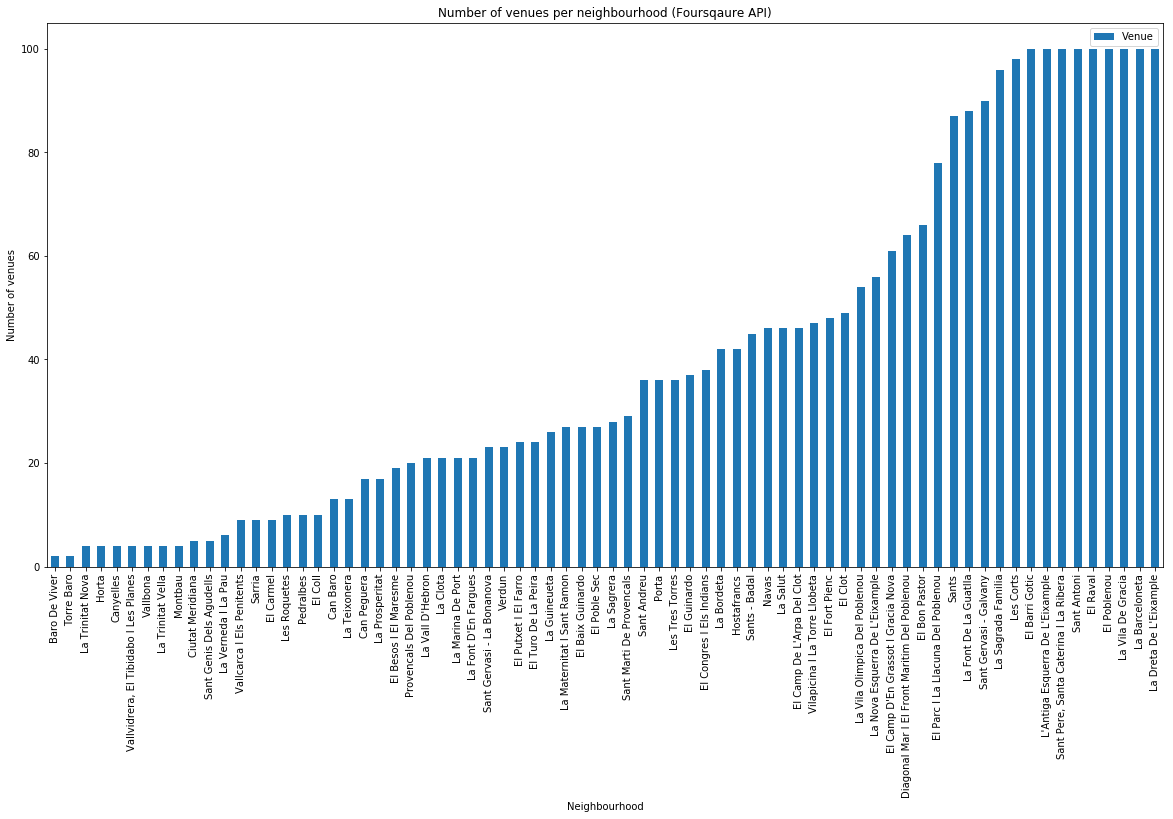

In [48]:
bcn_venues_count = bcn_venues[['Venue','N_Neigh']].groupby('N_Neigh').count()
bcn_venues_count.sort_values('Venue',inplace=True)
bcn_venues_count.reset_index()
bcn_venues_count.plot(kind='bar', figsize=(20,10))
plt.title("Number of venues per neighbourhood (Foursqaure API)")
plt.xlabel('Neighbourhood')
plt.ylabel('Number of venues')
plt.savefig('graphics/venues.png')
plt.show()

We create a one hot encoding dataframe to classify neighbourhoods by occurrence of each category

In [49]:
# one hot encoding
bcn_onehot_4sq = pd.get_dummies(bcn_venues[['Venue_Category']], prefix="", prefix_sep="")

# add neighborhood code and name columns back to dataframe
bcn_onehot_4sq['C_Neigh'] = bcn_venues['C_Neigh'] 
bcn_onehot_4sq['N_Neigh'] = bcn_venues['N_Neigh'] 

# move neighborhood column to the first column
fixed_columns = [bcn_onehot_4sq.columns[-2]] + [bcn_onehot_4sq.columns[-1]] + list(bcn_onehot_4sq.columns[:-2])
bcn_onehot_4sq = bcn_onehot_4sq[fixed_columns]

print(bcn_onehot_4sq.shape)
bcn_onehot_4sq.head()

(2878, 274)


C_Neigh   N_Neigh  Accessories Store  African Restaurant  \
0      01  El Raval                  0                   0   
1      01  El Raval                  0                   0   
2      01  El Raval                  0                   0   
3      01  El Raval                  0                   0   
4      01  El Raval                  0                   0   

   American Restaurant  Amphitheater  Antique Shop  Arcade  Arepa Restaurant  \
0                    0             0             0       0                 0   
1                    0             0             0       0                 0   
2                    0             0             0       0                 0   
3                    0             0             0       0                 0   
4                    0             0             0       0                 0   

   Argentinian Restaurant     ...       Venezuelan Restaurant  Veterinarian  \
0                       0     ...                           0             0   
1                       0     ...                           0             0   
2                       0     ...                           0             0   
3                       0     ...                           0             0   
4                       0     ...                           0             0   

   Video Game Store  Video Store  Vietnamese Restaurant  Wine Bar  Wine Shop  \
0                 0            0                      0         0          0   
1                 0            0                      0         0          0   
2                 0            0                      0         0          0   
3                 0            0                      0         0          0   
4                 0            0                      0         0          0   

   Wings Joint  Women's Store  Yoga Studio  
0            0              0            0  
1            0              0            0  
2            0              0            0  
3            0              0            0  
4            0              0            0  

[5 rows x 274 columns]

Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [50]:
bcn_grouped_4sq = bcn_onehot_4sq.groupby(['C_Neigh','N_Neigh']).mean().reset_index()
print(bcn_grouped_4sq.shape)
bcn_grouped_4sq

(72, 274)


C_Neigh                                       N_Neigh  Accessories Store  \
0       01                                      El Raval           0.010000   
1       02                                El Barri Gotic           0.000000   
2       03                                La Barceloneta           0.000000   
3       04         Sant Pere, Santa Caterina I La Ribera           0.000000   
4       05                                 El Fort Pienc           0.000000   
5       06                            La Sagrada Familia           0.000000   
6       07                        La Dreta De L'Eixample           0.000000   
7       08               L'Antiga Esquerra De L'Eixample           0.000000   
8       09                La Nova Esquerra De L'Eixample           0.000000   
9       10                                   Sant Antoni           0.000000   
10      11                                  El Poble Sec           0.000000   
11      13                             La Marina De Port           0.000000   
12      14                         La Font De La Guatlla           0.000000   
13      15                                   Hostafrancs           0.000000   
14      16                                    La Bordeta           0.000000   
15      17                                 Sants - Badal           0.000000   
16      18                                         Sants           0.000000   
17      19                                     Les Corts           0.010204   
18      20                    La Maternitat I Sant Ramon           0.000000   
19      21                                     Pedralbes           0.000000   
20      22         Vallvidrera, El Tibidabo I Les Planes           0.000000   
21      23                                        Sarria           0.000000   
22      24                               Les Tres Torres           0.000000   
23      25                    Sant Gervasi - La Bonanova           0.000000   
24      26                        Sant Gervasi - Galvany           0.000000   
25      27                          El Putxet I El Farro           0.000000   
26      28                     Vallcarca I Els Penitents           0.000000   
27      29                                       El Coll           0.000000   
28      30                                      La Salut           0.000000   
29      31                             La Vila De Gracia           0.000000   
..     ...                                           ...                ...   
42      44                 Vilapicina I La Torre Llobeta           0.000000   
43      45                                         Porta           0.000000   
44      46                           El Turo De La Peira           0.000000   
45      47                                   Can Peguera           0.000000   
46      48                                  La Guineueta           0.000000   
47      49                                     Canyelles           0.000000   
48      50                                  Les Roquetes           0.000000   
49      51                                        Verdun           0.000000   
50      52                                La Prosperitat           0.000000   
51      53                              La Trinitat Nova           0.000000   
52      54                                    Torre Baro           0.000000   
53      55                              Ciutat Meridiana           0.000000   
54      56                                      Vallbona           0.000000   
55      57                             La Trinitat Vella           0.000000   
56      58                                 Baro De Viver           0.000000   
57      59                                 El Bon Pastor           0.030303   
58      60                                   Sant Andreu           0.000000   
59      61                                    La Sagrera           0.000000   
60      62                      El Congres I Els Indi

In [51]:
bcn_grouped_4sq.T

0               1               2   \
C_Neigh                              01              02              03   
N_Neigh                        El Raval  El Barri Gotic  La Barceloneta   
Accessories Store                  0.01               0               0   
African Restaurant                    0               0               0   
American Restaurant                   0               0               0   
Amphitheater                          0               0               0   
Antique Shop                          0               0               0   
Arcade                                0               0               0   
Arepa Restaurant                      0               0               0   
Argentinian Restaurant                0               0            0.01   
Art Gallery                           0            0.01               0   
Art Museum                            0            0.01               0   
Arts & Crafts Store                   0               0               0   
Asian Restaurant                   0.01               0               0   
Athletics & Sports                    0               0               0   
Auto Dealership                       0               0               0   
Auto Garage                           0               0               0   
BBQ Joint                             0               0            0.01   
Baby Store                         0.01               0               0   
Bagel Shop                            0               0               0   
Bakery                             0.01               0            0.02   
Bar                                0.03            0.04            0.07   
Basketball Court                      0               0               0   
Basketball Stadium                    0               0               0   
Beach                                 0               0            0.03   
Beach Bar                             0               0            0.02   
Bed & Breakfast                       0               0               0   
Beer Bar                           0.02               0            0.02   
Beer Garden                           0               0               0   
Beer Store                            0               0               0   
...                                 ...             ...             ...   
Swiss Restaurant                      0               0               0   
Taco Place                            0               0               0   
Tapas Restaurant                   0.11            0.09            0.09   
Tea Room                              0            0.03               0   
Tech Startup                          0               0               0   
Tennis Court                          0               0               0   
Thai Restaurant                       0               0               0   
Theater                            0.02               0               0   
Theme Park                            0               0               0   
Theme Park Ride / Attraction          0               0               0   
Theme Restaurant                      0               0               0   
Toy / Game Store                      0               0               0   
Track                                 0               0               0   
Trail                                 0               0               0   
Train Station                         0               0               0   
Tram Station                          0               0               0   
Transportation Service                0               0               0   
Turkish Restaurant                    0               0            0.01   
Udon Restaurant                       0               0               0   
Vegetarian / Vegan Restaurant         0            0.05            0.01   
Venezuelan Restaurant                 0               0               0   
Veterinarian                          0               0       

Print each neighborhood along with the top 5 most common venues

In [52]:
num_top_venues = 5

for hood in bcn_grouped_4sq['N_Neigh']:
    print("----"+hood+"----")
    temp = bcn_grouped_4sq[bcn_grouped_4sq['N_Neigh'] == hood].T.reset_index()
    temp.columns = ['activity','freq']
    temp = temp.iloc[2:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----El Raval----
             activity  freq
0    Tapas Restaurant  0.11
1               Hotel  0.06
2  Spanish Restaurant  0.05
3                Café  0.04
4      Ice Cream Shop  0.04


----El Barri Gotic----
                        activity  freq
0               Tapas Restaurant  0.09
1             Spanish Restaurant  0.08
2                       Wine Bar  0.06
3                          Plaza  0.05
4  Vegetarian / Vegan Restaurant  0.05


----La Barceloneta----
                   activity  freq
0         Paella Restaurant  0.10
1          Tapas Restaurant  0.09
2  Mediterranean Restaurant  0.09
3                       Bar  0.07
4        Spanish Restaurant  0.06


----Sant Pere, Santa Caterina I La Ribera----
             activity  freq
0    Tapas Restaurant  0.08
1  Italian Restaurant  0.05
2               Hotel  0.05
3                 Bar  0.05
4                Café  0.04


----El Fort Pienc----
     activity  freq
0      Hostel  0.08
1  Restaurant  0.08
2       Hotel  0.06
3     T

             activity  freq
0      Scenic Lookout  0.25
1        Soccer Field  0.25
2          Kids Store  0.25
3  Spanish Restaurant  0.25
4              Palace  0.00


----Vilapicina I La Torre Llobeta----
           activity  freq
0     Grocery Store  0.09
1             Plaza  0.06
2  Tapas Restaurant  0.06
3               Bar  0.06
4              Café  0.06


----Porta----
           activity  freq
0  Tapas Restaurant  0.14
1             Plaza  0.08
2    Clothing Store  0.06
3       Pizza Place  0.06
4     Grocery Store  0.06


----El Turo De La Peira----
           activity  freq
0     Grocery Store  0.12
1              Café  0.12
2  Tapas Restaurant  0.12
3       Supermarket  0.08
4       Comedy Club  0.04


----Can Peguera----
             activity  freq
0       Grocery Store  0.12
1                Park  0.12
2               Plaza  0.12
3  Seafood Restaurant  0.12
4               Diner  0.06


----La Guineueta----
             activity  freq
0               Plaza  0.12
1       G

This metric can be mean, distance between data points and their cluster's centroid. Which indicate how dense our clusters are or, to what extent we minimize the error of clustering. Then, looking at the change of this metric, we can find the best value for K. But the problem is that with increasing the number of clusters, the distance of centroids to data points will always reduce. This means increasing K will always decrease the error. So, the value of the metric as a function of K is plotted and the elbow point is determined where the rate of decrease sharply shifts. It is the right K for clustering. This method is called the elbow method

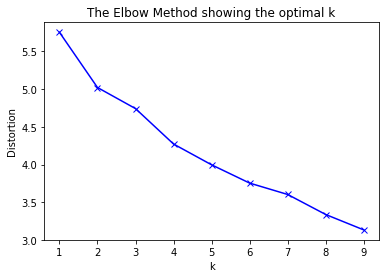

In [53]:
bcn_grouped_4sq_clustering = bcn_grouped_4sq.drop(['C_Neigh','N_Neigh'],1)

# clustering dataset
# determine k using elbow method

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k,random_state=0).fit(bcn_grouped_4sq_clustering)
    #distortions.append(sum(np.min(cdist(bcn_grouped_4sq_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / bcn_grouped_4sq_clustering.shape[0])
    distortions.append(kmeanModel.inertia_)
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.savefig('graphics/elbow_venues.png')
plt.show() 

Although elbow method in this case doesn't show a perfect elbow, we see that with k=5 there is a minor change is the slope, so we are going to consider 5 as the optimal number of clusters

Run k-means to cluster the neighborhood into 5 clusters.

In [54]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeanModel = KMeans(n_clusters=kclusters, random_state=0).fit(bcn_grouped_4sq_clustering)

# check cluster labels generated for each row in the dataframe
kmeanModel.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 4, 4, 2, 2, 2, 0, 1, 1, 2, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1])

Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

Write a function to sort the venues in descending order.

In [55]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the top 10 venues for each neighborhood.

In [56]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['C_Neigh','N_Neigh']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# create a new dataframe
bcn_neigh_venues_sorted_4sq = pd.DataFrame(columns=columns)
bcn_neigh_venues_sorted_4sq['C_Neigh'] = bcn_grouped_4sq['C_Neigh']
bcn_neigh_venues_sorted_4sq['N_Neigh'] = bcn_grouped_4sq['N_Neigh']

for ind in np.arange(bcn_grouped_4sq.shape[0]):
    bcn_neigh_venues_sorted_4sq.iloc[ind, 2:] = return_most_common_venues(bcn_grouped_4sq.iloc[ind, :], num_top_venues)

bcn_neigh_venues_sorted_4sq.head()

C_Neigh                                N_Neigh 1st Most Common Venue  \
0      01                               El Raval      Tapas Restaurant   
1      02                         El Barri Gotic      Tapas Restaurant   
2      03                         La Barceloneta     Paella Restaurant   
3      04  Sant Pere, Santa Caterina I La Ribera      Tapas Restaurant   
4      05                          El Fort Pienc                Hostel   

  2nd Most Common Venue     3rd Most Common Venue  \
0                 Hotel        Spanish Restaurant   
1    Spanish Restaurant                  Wine Bar   
2      Tapas Restaurant  Mediterranean Restaurant   
3    Italian Restaurant                     Hotel   
4            Restaurant                   Theater   

           4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0                           Café                 Plaza        Ice Cream Shop   
1  Vegetarian / Vegan Restaurant                 Plaza          Cocktail Bar   
2                            Bar    Spanish Restaurant            Restaurant   
3                            Bar                  Café        Breakfast Spot   
4                          Hotel    Mexican Restaurant        Breakfast Spot   

      7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0  Mediterranean Restaurant            Restaurant                   Bar   
1                       Bar           Coffee Shop                 Hotel   
2            Ice Cream Shop    Seafood Restaurant                 Beach   
3              Cocktail Bar            Restaurant   Japanese Restaurant   
4                    Bakery                  Café    Spanish Restaurant   

  10th Most Common Venue  
0              Gift Shop  
1               Tea Room  
2           Burger Joint  
3       Asian Restaurant  
4           Tram Station

In [57]:
# add clustering labels
bcn_neigh_venues_sorted_4sq.insert(0, 'Cluster Labels', kmeanModel.labels_)
bcn_neigh_venues_sorted_4sq.head()

Cluster Labels C_Neigh                                N_Neigh  \
0               1      01                               El Raval   
1               1      02                         El Barri Gotic   
2               1      03                         La Barceloneta   
3               1      04  Sant Pere, Santa Caterina I La Ribera   
4               1      05                          El Fort Pienc   

  1st Most Common Venue 2nd Most Common Venue     3rd Most Common Venue  \
0      Tapas Restaurant                 Hotel        Spanish Restaurant   
1      Tapas Restaurant    Spanish Restaurant                  Wine Bar   
2     Paella Restaurant      Tapas Restaurant  Mediterranean Restaurant   
3      Tapas Restaurant    Italian Restaurant                     Hotel   
4                Hostel            Restaurant                   Theater   

           4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0                           Café                 Plaza        Ice Cream Shop   
1  Vegetarian / Vegan Restaurant                 Plaza          Cocktail Bar   
2                            Bar    Spanish Restaurant            Restaurant   
3                            Bar                  Café        Breakfast Spot   
4                          Hotel    Mexican Restaurant        Breakfast Spot   

      7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0  Mediterranean Restaurant            Restaurant                   Bar   
1                       Bar           Coffee Shop                 Hotel   
2            Ice Cream Shop    Seafood Restaurant                 Beach   
3              Cocktail Bar            Restaurant   Japanese Restaurant   
4                    Bakery                  Café    Spanish Restaurant   

  10th Most Common Venue  
0              Gift Shop  
1               Tea Room  
2           Burger Joint  
3       Asian Restaurant  
4           Tram Station

In order to add latitude and longitude to the cluster dataset (and other fields) we marge original dataset with the clustered dataset

In [58]:
bcn_neigh_venues_sorted_4sq2 = bcn_neigh_venues_sorted_4sq.drop(['N_Neigh'],1)
bcn_merged_4sq = pd.merge(bcn_neigh_venues_sorted_4sq2, bcn_neigh_df, how='inner', on=['C_Neigh'])
cols = list(bcn_merged_4sq.columns.values).copy()
cols.remove('N_Neigh')
cols.insert(2,'N_Neigh')
bcn_merged_4sq = bcn_merged_4sq[cols]
bcn_merged_4sq.head()

Cluster Labels C_Neigh                                N_Neigh  \
0               1      01                               El Raval   
1               1      02                         El Barri Gotic   
2               1      03                         La Barceloneta   
3               1      04  Sant Pere, Santa Caterina I La Ribera   
4               1      05                          El Fort Pienc   

  1st Most Common Venue 2nd Most Common Venue     3rd Most Common Venue  \
0      Tapas Restaurant                 Hotel        Spanish Restaurant   
1      Tapas Restaurant    Spanish Restaurant                  Wine Bar   
2     Paella Restaurant      Tapas Restaurant  Mediterranean Restaurant   
3      Tapas Restaurant    Italian Restaurant                     Hotel   
4                Hostel            Restaurant                   Theater   

           4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0                           Café                 Plaza        Ice Cream Shop   
1  Vegetarian / Vegan Restaurant                 Plaza          Cocktail Bar   
2                            Bar    Spanish Restaurant            Restaurant   
3                            Bar                  Café        Breakfast Spot   
4                          Hotel    Mexican Restaurant        Breakfast Spot   

      7th Most Common Venue  \
0  Mediterranean Restaurant   
1                       Bar   
2            Ice Cream Shop   
3              Cocktail Bar   
4                    Bakery   

                         ...                          Women          Area  \
0                        ...                          21850  1.098393e+06   
1                        ...                           7508  8.419051e+05   
2                        ...                           7631  1.313868e+06   
3                        ...                          11390  1.114299e+06   
4                        ...                          16924  9.289010e+05   

      Perimeter Longitude  Latitude                           WEB_1  \
0   5557.372878  2.171593  41.38081  http://www.bcn.cat/ciutatvella   
1   5683.004856  2.178549  41.38294  http://www.bcn.cat/ciutatvella   
2  13039.266793  2.191261  41.37905  http://www.bcn.cat/ciutatvella   
3   4658.031512  2.184539  41.38864  http://www.bcn.cat/ciutatvella   
4   4175.971325  2.182589  41.39926     http://www.bcn.cat/eixample   

                                               WEB_2  \
0  http://www.bcn.cat/estadistica/catala/dades/in...   
1  http://www.bcn.cat/estadistica/catala/dades/in...   
2  http://www.bcn.cat/estadistica/catala/dades/in...   
3  http://www.bcn.cat/estadistica/catala/dades/in...   
4  http://www.bcn.cat/estadistica/catala/dades/in...   

                                               WEB_3  \
0  http://www.bcn.cat/estadistica/catala/dades/gu...   
1  http://www.bcn.cat/estadistica/catala/dades/gu...   
2  http://www.bcn.cat/estadistica/catala/dades/gu...   
3  http://www.bcn.cat/estadistica/catala/dades/gu...   
4  http://www.bcn.cat/estadistica/catala/dades/gu...   

                                               WEB_4  \
0  http://www.bcn.cat/estadistica/catala/dades/in...   
1  http://www.bcn.cat/estadistica/catala/dades/in...   
2  http://www.bcn.cat/estadistica/catala/dades/in...   
3  http://www.bcn.cat/estadistica/catala/dades/in...   
4  http://www.bcn.cat/estadistica/catala/dades/in...   

                                              coords  
0  [(2.17114583251087, 41.387318300967955), (2.17...  
1  [(2.183565559937503, 41.38311899420626), (2.18...  
2  [(2.20082586629123, 41.38678345631065), (2.200...  
3  [(2.1834921087968935, 41.39327449798472), (2.1...  
4  [(2.1834921087968935, 41.39327449798472), (2.1...  

[5 rows x 26 columns]

#### b) Official Census of Premises dataset

Let's examine the amount of premises that have foound for each neighbourhood. As we can see the number of premises differs significantly respect to data obtained with Foursqaure API, so we are going to expect to obtain different clusters.

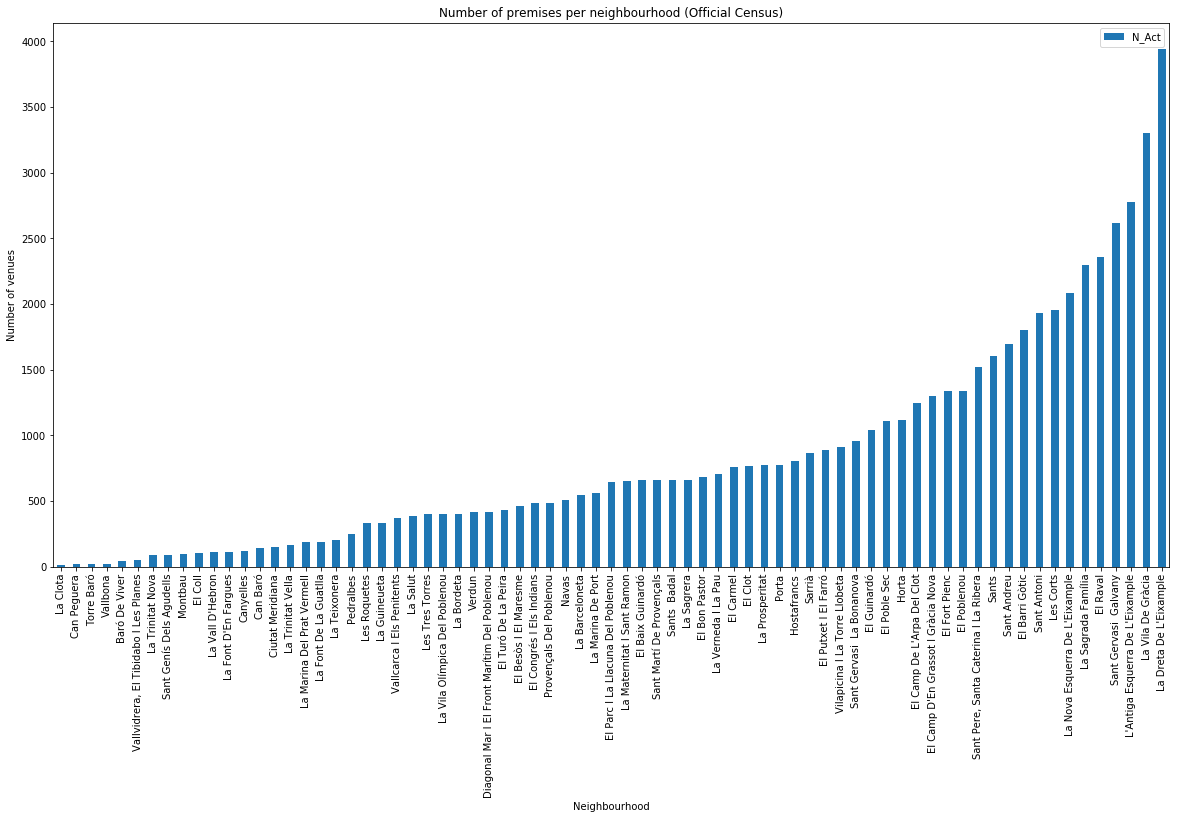

In [59]:
bcn_premises_count = bcn_premises_df[['N_Act','N_Neigh']].groupby('N_Neigh').count()
bcn_premises_count.sort_values('N_Act',inplace=True)
bcn_premises_count.reset_index()
bcn_premises_count.plot(kind='bar', figsize=(20,10))
plt.title("Number of premises per neighbourhood (Official Census)")
plt.xlabel('Neighbourhood')
plt.ylabel('Number of venues')
plt.savefig('graphics/premises.png')
plt.show()

We create a one hot encoding dataframe to classify neighbourhoods by occurrence of each category

In [60]:
# one hot encoding
bcn_onehot_census = pd.get_dummies(bcn_premises_df[['N_Act']], prefix="", prefix_sep="")

# add neighborhood code and name columns back to dataframe
bcn_onehot_census['C_Neigh'] = bcn_premises_df['C_Neigh'] 
bcn_onehot_census['N_Neigh'] = bcn_premises_df['N_Neigh'] 

# move neighborhood column to the first column
fixed_columns = [bcn_onehot_census.columns[-2]] + [bcn_onehot_census.columns[-1]] + list(bcn_onehot_census.columns[:-2])
bcn_onehot_census = bcn_onehot_census[fixed_columns]

print(bcn_onehot_census.shape)
bcn_onehot_census.head()

(60265, 63)


C_Neigh         N_Neigh  Activitats de la construcció  \
0      02  El Barri Gòtic                             0   
1      02  El Barri Gòtic                             0   
2      02  El Barri Gòtic                             0   
3      02  El Barri Gòtic                             0   
4      02  El Barri Gòtic                             0   

   Activitats de transport i emmagatzematge  Activitats immobiliàries  \
0                                         0                         0   
1                                         0                         0   
2                                         0                         0   
3                                         0                         0   
4                                         0                         0   

   Activitats industrials  Administració  Agències de viatge  Altres  \
0                       0              0                   0       0   
1                       0              0                   0       0   
2                       0              0                   0       0   
3                       0              0                   0       0   
4                       0              0                   0       0   

   Aparells domèstics           ...            \
0                   0           ...             
1                   0           ...             
2                   0           ...             
3                   0           ...             
4                   0           ...             

   Serveis a les empreses i oficines  Serveis d'allotjament  \
0                                  0                      0   
1                                  0                      0   
2                                  0                      0   
3                                  0                      0   
4                                  0                      0   

   Serveis de menjar i begudes  Serveis de telecomunicacions  \
0                            0                             0   
1                            1                             0   
2                            0                             0   
3                            0                             0   
4                            1                             0   

   Souvenirs i basars  Tabac i articles fumadors  Tintoreries  Vehicles  \
0                   0                          0            0         0   
1                   0                          0            0         0   
2                   0                          0            0         0   
3                   0                          0            0         0   
4                   0                          0            0         0   

   Vestir  Veterinaris / Mascotes  
0       1                       0  
1       0                       0  
2       1                       0  
3       0                       0  
4       0                       0  

[5 rows x 63 columns]

Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [61]:
bcn_grouped_census = bcn_onehot_census.groupby(['C_Neigh','N_Neigh']).mean().reset_index()
print(bcn_grouped_census.shape)
bcn_grouped_census

(73, 63)


C_Neigh                                       N_Neigh  \
0       01                                      El Raval   
1       02                                El Barri Gòtic   
2       03                                La Barceloneta   
3       04         Sant Pere, Santa Caterina I La Ribera   
4       05                                 El Fort Pienc   
5       06                            La Sagrada Família   
6       07                        La Dreta De L'Eixample   
7       08               L'Antiga Esquerra De L'Eixample   
8       09                La Nova Esquerra De L'Eixample   
9       10                                   Sant Antoni   
10      11                                  El Poble Sec   
11      12                    La Marina Del Prat Vermell   
12      13                             La Marina De Port   
13      14                         La Font De La Guatlla   
14      15                                   Hostafrancs   
15      16                                    La Bordeta   
16      17                                  Sants  Badal   
17      18                                         Sants   
18      19                                     Les Corts   
19      20                    La Maternitat I Sant Ramon   
20      21                                     Pedralbes   
21      22         Vallvidrera, El Tibidabo I Les Planes   
22      23                                        Sarrià   
23      24                               Les Tres Torres   
24      25                     Sant Gervasi  La Bonanova   
25      26                         Sant Gervasi  Galvany   
26      27                          El Putxet I El Farró   
27      28                     Vallcarca I Els Penitents   
28      29                                       El Coll   
29      30                                      La Salut   
..     ...                                           ...   
43      44                 Vilapicina I La Torre Llobeta   
44      45                                         Porta   
45      46                           El Turó De La Peira   
46      47                                   Can Peguera   
47      48                                  La Guineueta   
48      49                                     Canyelles   
49      50                                  Les Roquetes   
50      51                                        Verdun   
51      52                                La Prosperitat   
52      53                              La Trinitat Nova   
53      54                                    Torre Baró   
54      55                              Ciutat Meridiana   
55      56                                      Vallbona   
56      57                             La Trinitat Vella   
57      58                                 Baró De Viver   
58      59                                 El Bon Pastor   
59      60                                   Sant Andreu   
60      61                                    La Sagrera   
61      62                      El Congrés I Els Indians   
62      63                                         Navas   
63      64                    El Camp De L'Arpa Del Clot   
64      65                                       El Clot   
65      66             El Parc I La Llacuna Del Poblenou   
66      67                 La Vila Olímpica Del Poblenou   
67      68                                   El Poblenou   
68      69  Diagonal Mar I El Front Marítim Del Poblenou   
69      70                         El Besòs I El Maresme   
70      71                       Provençals Del Poblenou   
71      72                      Sant Martí De Provençals   
72      73                           La Verneda I La Pau   

    Activitats de la construcció  Activitats de transport i emmagatzematge  \
0                       0.014862                                  0.024628   
1                       0.004994                                  0.027747   
2                       0.012844                

Print each neighborhood along with the top 5 most common premises

In [62]:
num_top_venues = 5

for hood in bcn_grouped_census['N_Neigh']:
    print("----"+hood+"----")
    temp = bcn_grouped_census[bcn_grouped_census['N_Neigh'] == hood].T.reset_index()
    temp.columns = ['activity','freq']
    temp = temp.iloc[2:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----El Raval----
                      activity  freq
0  Serveis de menjar i begudes  0.17
1            Resta alimentació  0.07
2                       Vestir  0.06
3           Fruites i verdures  0.05
4                       Altres  0.05


----El Barri Gòtic----
                           activity  freq
0       Serveis de menjar i begudes  0.22
1                            Vestir  0.15
2                Souvenirs i basars  0.09
3  Joieria, rellotgeria i bijuteria  0.06
4                     Calçat i pell  0.05


----La Barceloneta----
                                   activity  freq
0               Serveis de menjar i begudes  0.34
1                         Resta alimentació  0.07
2  Activitats de transport i emmagatzematge  0.04
3                 Pa, pastisseria i làctics  0.04
4                              Perruqueries  0.04


----Sant Pere, Santa Caterina I La Ribera----
                      activity  freq
0  Serveis de menjar i begudes  0.20
1                       Vestir  0.13


                            activity  freq
0                  Resta alimentació  0.11
1        Serveis de menjar i begudes  0.10
2  Serveis a les empreses i oficines  0.10
3                             Altres  0.06
4       Activitats de la construcció  0.05


----La Salut----
                            activity  freq
0        Serveis de menjar i begudes  0.11
1                  Resta alimentació  0.08
2  Serveis a les empreses i oficines  0.08
3                 Souvenirs i basars  0.06
4                             Altres  0.05


----La Vila De Gràcia----
                            activity  freq
0        Serveis de menjar i begudes  0.13
1                             Vestir  0.08
2                             Altres  0.08
3                  Resta alimentació  0.05
4  Serveis a les empreses i oficines  0.05


----El Camp D'En Grassot I Gràcia Nova----
                            activity  freq
0        Serveis de menjar i begudes  0.10
1                  Resta alimentació  0.06
2    

                            activity  freq
0        Serveis de menjar i begudes  0.14
1                       Perruqueries  0.06
2                             Altres  0.05
3                  Resta alimentació  0.05
4  Serveis a les empreses i oficines  0.04


----El Clot----
                            activity  freq
0        Serveis de menjar i begudes  0.17
1                       Perruqueries  0.06
2                  Resta alimentació  0.06
3  Serveis a les empreses i oficines  0.05
4                        Ensenyament  0.04


----El Parc I La Llacuna Del Poblenou----
                                      activity  freq
0                  Serveis de menjar i begudes  0.22
1            Serveis a les empreses i oficines  0.10
2     Activitats de transport i emmagatzematge  0.09
3  Reparacions (Electrodomèstics i automòbils)  0.05
4                                       Altres  0.05


----La Vila Olímpica Del Poblenou----
                                   activity  freq
0             

We apply the elbow method as we did before with Foursquare dataser

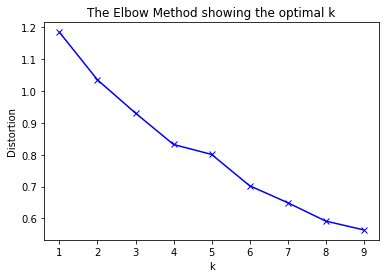

In [63]:
bcn_grouped_census_clustering = bcn_grouped_census.drop(['C_Neigh','N_Neigh'],1)

# clustering dataset
# determine k using elbow method

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k,random_state=0).fit(bcn_grouped_census_clustering)
    #distortions.append(sum(np.min(cdist(bcn_grouped_census_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / bcn_grouped_census_clustering.shape[0])
    distortions.append(kmeanModel.inertia_)
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.savefig('graphics/elbow_premises.png')
plt.show() 

In this case we do not see a perfect elbow. However we are going to consider k=5 in order that the number of clusters fits with the ones found in Foursquare. 

Run k-means to cluster the neighborhood into 5 clusters.

In [64]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeanModel = KMeans(n_clusters=kclusters, random_state=0).fit(bcn_grouped_census_clustering)

# check cluster labels generated for each row in the dataframe
kmeanModel.labels_

array([3, 1, 3, 1, 0, 3, 1, 3, 3, 3, 3, 2, 3, 0, 3, 0, 3, 3, 3, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 3, 3, 3, 0, 4, 0, 0,
       3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 2, 3, 3, 3, 3, 3, 3, 0,
       3, 3, 1, 3, 0, 3, 3])

Create the new dataframe and display the top 10 venues for each neighborhood.

In [65]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['C_Neigh','N_Neigh']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# create a new dataframe
bcn_neigh_venues_sorted_census = pd.DataFrame(columns=columns)
bcn_neigh_venues_sorted_census['C_Neigh'] = bcn_grouped_census['C_Neigh']
bcn_neigh_venues_sorted_census['N_Neigh'] = bcn_grouped_census['N_Neigh']

for ind in np.arange(bcn_grouped_census.shape[0]):
    bcn_neigh_venues_sorted_census.iloc[ind, 2:] = return_most_common_venues(bcn_grouped_census.iloc[ind, :], num_top_venues)

bcn_neigh_venues_sorted_census.head()

C_Neigh                                N_Neigh        1st Most Common Venue  \
0      01                               El Raval  Serveis de menjar i begudes   
1      02                         El Barri Gòtic  Serveis de menjar i begudes   
2      03                         La Barceloneta  Serveis de menjar i begudes   
3      04  Sant Pere, Santa Caterina I La Ribera  Serveis de menjar i begudes   
4      05                          El Fort Pienc                       Altres   

         2nd Most Common Venue                     3rd Most Common Venue  \
0            Resta alimentació                                    Vestir   
1                       Vestir                        Souvenirs i basars   
2            Resta alimentació                 Pa, pastisseria i làctics   
3                       Vestir                         Resta alimentació   
4  Serveis de menjar i begudes  Activitats de transport i emmagatzematge   

                      4th Most Common Venue 5th Most Common Venue  \
0                        Fruites i verdures                Altres   
1          Joieria, rellotgeria i bijuteria         Calçat i pell   
2  Activitats de transport i emmagatzematge          Perruqueries   
3                 Pa, pastisseria i làctics    Souvenirs i basars   
4         Serveis a les empreses i oficines     Resta alimentació   

       6th Most Common Venue                        7th Most Common Venue  \
0                Carn i Porc                           Souvenirs i basars   
1  Pa, pastisseria i làctics                        Serveis d'allotjament   
2         Souvenirs i basars                                  Ensenyament   
3              Calçat i pell           Equipaments culturals i recreatius   
4               Perruqueries  Reparacions (Electrodomèstics i automòbils)   

          8th Most Common Venue                     9th Most Common Venue  \
0                   Informàtica                 Pa, pastisseria i làctics   
1                        Altres  Activitats de transport i emmagatzematge   
2                   Carn i Porc                                    Altres   
3      Material equipament llar          Joieria, rellotgeria i bijuteria   
4  Activitats de la construcció                               Ensenyament   

               10th Most Common Venue  
0                        Perruqueries  
1  Equipaments culturals i recreatius  
2                  Fruites i verdures  
3                        Perruqueries  
4           Pa, pastisseria i làctics

In [66]:
# add clustering labels
bcn_neigh_venues_sorted_census.insert(0, 'Cluster Labels', kmeanModel.labels_)
bcn_neigh_venues_sorted_census.head()

Cluster Labels C_Neigh                                N_Neigh  \
0               3      01                               El Raval   
1               1      02                         El Barri Gòtic   
2               3      03                         La Barceloneta   
3               1      04  Sant Pere, Santa Caterina I La Ribera   
4               0      05                          El Fort Pienc   

         1st Most Common Venue        2nd Most Common Venue  \
0  Serveis de menjar i begudes            Resta alimentació   
1  Serveis de menjar i begudes                       Vestir   
2  Serveis de menjar i begudes            Resta alimentació   
3  Serveis de menjar i begudes                       Vestir   
4                       Altres  Serveis de menjar i begudes   

                      3rd Most Common Venue  \
0                                    Vestir   
1                        Souvenirs i basars   
2                 Pa, pastisseria i làctics   
3                         Resta alimentació   
4  Activitats de transport i emmagatzematge   

                      4th Most Common Venue 5th Most Common Venue  \
0                        Fruites i verdures                Altres   
1          Joieria, rellotgeria i bijuteria         Calçat i pell   
2  Activitats de transport i emmagatzematge          Perruqueries   
3                 Pa, pastisseria i làctics    Souvenirs i basars   
4         Serveis a les empreses i oficines     Resta alimentació   

       6th Most Common Venue                        7th Most Common Venue  \
0                Carn i Porc                           Souvenirs i basars   
1  Pa, pastisseria i làctics                        Serveis d'allotjament   
2         Souvenirs i basars                                  Ensenyament   
3              Calçat i pell           Equipaments culturals i recreatius   
4               Perruqueries  Reparacions (Electrodomèstics i automòbils)   

          8th Most Common Venue                     9th Most Common Venue  \
0                   Informàtica                 Pa, pastisseria i làctics   
1                        Altres  Activitats de transport i emmagatzematge   
2                   Carn i Porc                                    Altres   
3      Material equipament llar          Joieria, rellotgeria i bijuteria   
4  Activitats de la construcció                               Ensenyament   

               10th Most Common Venue  
0                        Perruqueries  
1  Equipaments culturals i recreatius  
2                  Fruites i verdures  
3                        Perruqueries  
4           Pa, pastisseria i làctics

In order to add latitude and longitude to the cluster dataset (and other fields) we marge original dataset with the clustered dataset

In order to add latitude and longitude to the cluster dataset (and other fields) we marge original dataset with the clustered dataset

In [67]:
bcn_neigh_venues_sorted_census2 = bcn_neigh_venues_sorted_census.drop("N_Neigh",1)
bcn_merged_census = pd.merge(bcn_neigh_venues_sorted_census2, bcn_neigh_df, how='inner', on=['C_Neigh'])
cols = list(bcn_merged_census.columns.values).copy()
cols.remove('N_Neigh')
cols.insert(2,'N_Neigh')
bcn_merged_census = bcn_merged_census[cols]
print(bcn_merged_census.shape)
bcn_merged_census

(73, 26)


Cluster Labels C_Neigh                                       N_Neigh  \
0                3      01                                      El Raval   
1                1      02                                El Barri Gotic   
2                3      03                                La Barceloneta   
3                1      04         Sant Pere, Santa Caterina I La Ribera   
4                0      05                                 El Fort Pienc   
5                3      06                            La Sagrada Familia   
6                1      07                        La Dreta De L'Eixample   
7                3      08               L'Antiga Esquerra De L'Eixample   
8                3      09                La Nova Esquerra De L'Eixample   
9                3      10                                   Sant Antoni   
10               3      11                                  El Poble Sec   
11               2      12                    La Marina Del Prat Vermell   
12               3      13                             La Marina De Port   
13               0      14                         La Font De La Guatlla   
14               3      15                                   Hostafrancs   
15               0      16                                    La Bordeta   
16               3      17                                 Sants - Badal   
17               3      18                                         Sants   
18               3      19                                     Les Corts   
19               0      20                    La Maternitat I Sant Ramon   
20               0      21                                     Pedralbes   
21               0      22         Vallvidrera, El Tibidabo I Les Planes   
22               0      23                                        Sarria   
23               0      24                               Les Tres Torres   
24               0      25                    Sant Gervasi - La Bonanova   
25               1      26                        Sant Gervasi - Galvany   
26               0      27                          El Putxet I El Farro   
27               0      28                     Vallcarca I Els Penitents   
28               0      29                                       El Coll   
29               0      30                                      La Salut   
..             ...     ...                                           ...   
43               0      44                 Vilapicina I La Torre Llobeta   
44               3      45                                         Porta   
45               3      46                           El Turo De La Peira   
46               0      47                                   Can Peguera   
47               0      48                                  La Guineueta   
48               3      49                                     Canyelles   
49               3      50                                  Les Roquetes   
50               3      51                                        Verdun   
51               3      52                                La Prosperitat   
52               3      53                              La Trinitat Nova   
53               3      54                                    Torre Baro   
54               3      55                              Ciutat Meridiana   
55               0      56                                      Vallbona   
56               3      57                             La Trinitat Vella   
57               3      58                                 Baro De Viver   
58               2      59                                 El Bon Pastor   
59               3      60                                   Sant Andreu   
60               3      61                                    La Sagrera   
61               3      62                      El Congres I Els Indians   
62               3      63                                         Navas   
63               3      64                    El Cam

## 4. Results

#### a) Foursquare

<b>Examine the clusters</b>

<u>Cluster 1</u>

In [68]:
bcn_merged_4sq.loc[bcn_merged_4sq['Cluster Labels'] == 0]

Cluster Labels C_Neigh        N_Neigh 1st Most Common Venue  \
56               0      58  Baro De Viver                  Park   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
56               Dog Run        Farmers Market  Ethiopian Restaurant   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
56           Event Space               Exhibit           Fabric Shop   

                          ...                         Women           Area  \
56                        ...                          1304  229918.434443   

      Perimeter Longitude  Latitude                          WEB_1  \
56  2236.437926  2.200104  41.44765  http://www.bcn.cat/santandreu   

                                                WEB_2  \
56  http://www.bcn.cat/estadistica/catala/dades/in...   

                                                WEB_3  \
56  http://www.bcn.cat/estadistica/catala/dades/gu...   

                                                WEB_4  \
56  http://www.bcn.cat/estadistica/catala/dades/in...   

                                               coords  
56  [(2.204420025780225, 41.44884512843636), (2.20...  

[1 rows x 26 columns]

<u>Cluster 2</u>

In [69]:
bcn_merged_4sq.loc[bcn_merged_4sq['Cluster Labels'] == 1]

Cluster Labels C_Neigh                                       N_Neigh  \
0                1      01                                      El Raval   
1                1      02                                El Barri Gotic   
2                1      03                                La Barceloneta   
3                1      04         Sant Pere, Santa Caterina I La Ribera   
4                1      05                                 El Fort Pienc   
5                1      06                            La Sagrada Familia   
6                1      07                        La Dreta De L'Eixample   
7                1      08               L'Antiga Esquerra De L'Eixample   
8                1      09                La Nova Esquerra De L'Eixample   
9                1      10                                   Sant Antoni   
11               1      13                             La Marina De Port   
12               1      14                         La Font De La Guatlla   
13               1      15                                   Hostafrancs   
14               1      16                                    La Bordeta   
15               1      17                                 Sants - Badal   
16               1      18                                         Sants   
17               1      19                                     Les Corts   
22               1      24                               Les Tres Torres   
24               1      26                        Sant Gervasi - Galvany   
25               1      27                          El Putxet I El Farro   
26               1      28                     Vallcarca I Els Penitents   
28               1      30                                      La Salut   
29               1      31                             La Vila De Gracia   
30               1      32            El Camp D'En Grassot I Gracia Nova   
33               1      35                                   El Guinardo   
34               1      36                          La Font D'En Fargues   
57               1      59                                 El Bon Pastor   
58               1      60                                   Sant Andreu   
60               1      62                      El Congres I Els Indians   
62               1      64                    El Camp De L'Arpa Del Clot   
63               1      65                                       El Clot   
64               1      66             El Parc I La Llacuna Del Poblenou   
65               1      67                 La Vila Olimpica Del Poblenou   
66               1      68                                   El Poblenou   
67               1      69  Diagonal Mar I El Front Maritim Del Poblenou   
68               1      70                         El Besos I El Maresme   
69               1      71                       Provencals Del Poblenou   
71               1      73                           La Verneda I La Pau   

       1st Most Common Venue     2nd Most Common Venue  \
0           Tapas Restaurant                     Hotel   
1           Tapas Restaurant        Spanish Restaurant   
2          Paella Restaurant          Tapas Restaurant   
3           Tapas Restaurant        Italian Restaurant   
4                     Hostel                Restaurant   
5                     Bakery                Restaurant   
6                      Hotel                    Hostel   
7               Cocktail Bar                     Hotel   
8                       Café        Spanish Restaurant   
9   Mediterranean Restaurant                      Café   
11                      Café             Grocery Store   
12        Spanish Restaurant                     Plaza   
13                     Hotel                Restaurant   
14                       Bar  Mediterranean Restaurant   
15                    Bakery               Pizza Place   
16                       Bar                Restaurant   
17        Spanish Restaurant                Restauran

<u>Cluster 3</u>

In [70]:
bcn_merged_4sq.loc[bcn_merged_4sq['Cluster Labels'] == 2]

Cluster Labels C_Neigh                                N_Neigh  \
10               2      11                           El Poble Sec   
18               2      20             La Maternitat I Sant Ramon   
19               2      21                              Pedralbes   
20               2      22  Vallvidrera, El Tibidabo I Les Planes   
21               2      23                                 Sarria   
23               2      25             Sant Gervasi - La Bonanova   
27               2      29                                El Coll   
31               2      33                       El Baix Guinardo   
32               2      34                               Can Baro   
35               2      37                              El Carmel   
36               2      38                           La Teixonera   
38               2      40                                Montbau   
39               2      41                       La Vall D'Hebron   
40               2      42                               La Clota   
41               2      43                                  Horta   
42               2      44          Vilapicina I La Torre Llobeta   
43               2      45                                  Porta   
44               2      46                    El Turo De La Peira   
45               2      47                            Can Peguera   
46               2      48                           La Guineueta   
47               2      49                              Canyelles   
48               2      50                           Les Roquetes   
49               2      51                                 Verdun   
50               2      52                         La Prosperitat   
53               2      55                       Ciutat Meridiana   
54               2      56                               Vallbona   
55               2      57                      La Trinitat Vella   
59               2      61                             La Sagrera   
61               2      63                                  Navas   
70               2      72               Sant Marti De Provencals   

       1st Most Common Venue 2nd Most Common Venue     3rd Most Common Venue  \
10  Mediterranean Restaurant               Theater                      Park   
18            Soccer Stadium          Soccer Field       Sporting Goods Shop   
19  Mediterranean Restaurant                Garden                     Plaza   
20              Soccer Field         Grocery Store                    Buffet   
21          Tapas Restaurant               Dog Run                Print Shop   
23                      Park           Planetarium            Science Museum   
27                      Park                 Plaza             Grocery Store   
31                     Hotel      Tapas Restaurant                      Park   
32                     Plaza        Scenic Lookout          Basketball Court   
35                     Plaza           Coffee Shop                     Trail   
36             Metro Station                Hostel                       Gym   
38                     Plaza        Breakfast Spot                       Gym   
39                     Plaza                   Gym        Spanish Restaurant   
40                    Bakery                 Plaza                    Hostel   
41                Kids Store    Spanish Restaurant              Soccer Field   
42             Grocery Store                  Café                       Bar   
43          Tapas Restaurant                 Plaza        Spanish Restaurant   
44          Tapas Restaurant                  Café             Grocery Store   
45                     Plaza         Grocery Store        Seafood Restaurant   
46                     Plaza         Grocery Store        Seafood Restaurant   
47                  Mountain        Clothing Store  Mediterranean Restaurant   
48        Spanish Restaurant              Gym Pool                    Castle   
49        Spanish Restau

<u>Cluster 4</u>

In [71]:
bcn_merged_4sq.loc[bcn_merged_4sq['Cluster Labels'] == 3]

Cluster Labels C_Neigh                   N_Neigh 1st Most Common Venue  \
37               3      39  Sant Genis Dels Agudells        Scenic Lookout   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
37            Sports Bar           Supermarket    Falafel Restaurant   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
37   Dumpling Restaurant     Electronics Store  Ethiopian Restaurant   

                          ...                         Women          Area  \
37                        ...                          3662  1.716026e+06   

      Perimeter Longitude  Latitude                              WEB_1  \
37  8060.995571  2.131278  41.42722  http://www.bcn.cat/horta-guinardo   

                                                WEB_2  \
37  http://www.bcn.cat/estadistica/catala/dades/in...   

                                                WEB_3  \
37  http://www.bcn.cat/estadistica/catala/dades/gu...   

                                                WEB_4  \
37  http://www.bcn.cat/estadistica/catala/dades/in...   

                                               coords  
37  [(2.1434301282413393, 41.426632484378885), (2....  

[1 rows x 26 columns]

<u>Cluster 5</u>

In [72]:
bcn_merged_4sq.loc[bcn_merged_4sq['Cluster Labels'] == 4]

Cluster Labels C_Neigh           N_Neigh 1st Most Common Venue  \
51               4      53  La Trinitat Nova         Metro Station   
52               4      54        Torre Baro         Metro Station   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
51                  Park    Spanish Restaurant        Breakfast Spot   
52                  Park                  Food     Fondue Restaurant   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
51  Fast Food Restaurant           Event Space               Exhibit   
52           Flower Shop           Flea Market           Fish Market   

                          ...                         Women          Area  \
51                        ...                          3914  5.600808e+05   
52                        ...                          1351  1.768413e+06   

      Perimeter Longitude  Latitude                         WEB_1  \
51  3924.509651  2.185892  41.45232  http://www.bcn.cat/noubarris   
52  7787.149915  2.175260  41.45671  http://www.bcn.cat/noubarris   

                                                WEB_2  \
51  http://www.bcn.cat/estadistica/catala/dades/in...   
52  http://www.bcn.cat/estadistica/catala/dades/in...   

                                                WEB_3  \
51  http://www.bcn.cat/estadistica/catala/dades/gu...   
52  http://www.bcn.cat/estadistica/catala/dades/gu...   

                                                WEB_4  \
51  http://www.bcn.cat/estadistica/catala/dades/in...   
52  http://www.bcn.cat/estadistica/catala/dades/in...   

                                               coords  
51  [(2.1895238947668183, 41.45677955769396), (2.1...  
52  [(2.1886872429389728, 41.458483472939626), (2....  

[2 rows x 26 columns]

In order to proper label the clusters we find the number of 10 venues on each cluster

In [78]:
bcn_venues_cluster = pd.merge(bcn_venues, bcn_merged_4sq[['C_Neigh','Cluster Labels']], how='inner', on=['C_Neigh'])

# one hot encoding
bcn_onehot_venues_cluster = pd.get_dummies(bcn_venues_cluster[['Venue_Category']], prefix="", prefix_sep="")

# add neighborhood code and name columns back to dataframe
bcn_onehot_venues_cluster['Cluster Labels'] = bcn_venues_cluster['Cluster Labels'] 

# move neighborhood column to the first column
fixed_columns = [bcn_onehot_venues_cluster.columns[-2]] + [bcn_onehot_venues_cluster.columns[-1]] + list(bcn_onehot_venues_cluster.columns[:-2])
bcn_onehot_census = bcn_onehot_venues_cluster[fixed_columns]

#Calculate the frequency of each venue category for each cluster
bcn_grouped_venues_cluster = bcn_onehot_venues_cluster.groupby(['Cluster Labels']).mean().reset_index()
print(bcn_grouped_venues_cluster.shape)
bcn_grouped_venues_cluster

(5, 273)


Cluster Labels  Accessories Store  African Restaurant  American Restaurant  \
0               0           0.000000             0.00000             0.000000   
1               1           0.001722             0.00043             0.001722   
2               2           0.000000             0.00000             0.000000   
3               3           0.000000             0.00000             0.000000   
4               4           0.000000             0.00000             0.000000   

   Amphitheater  Antique Shop    Arcade  Arepa Restaurant  \
0       0.00000       0.00000  0.000000          0.000000   
1       0.00043       0.00043  0.000861          0.000861   
2       0.00000       0.00000  0.000000          0.000000   
3       0.00000       0.00000  0.000000          0.000000   
4       0.00000       0.00000  0.000000          0.000000   

   Argentinian Restaurant  Art Gallery     ...       Venezuelan Restaurant  \
0                0.000000     0.000000     ...                    0.000000   
1                0.005166     0.004305     ...                    0.000861   
2                0.000000     0.000000     ...                    0.000000   
3                0.000000     0.000000     ...                    0.000000   
4                0.000000     0.000000     ...                    0.000000   

   Veterinarian  Video Game Store  Video Store  Vietnamese Restaurant  \
0      0.000000          0.000000     0.000000               0.000000   
1      0.000000          0.000430     0.000430               0.001291   
2      0.001845          0.001845     0.001845               0.000000   
3      0.000000          0.000000     0.000000               0.000000   
4      0.000000          0.000000     0.000000               0.000000   

   Wine Bar  Wine Shop  Wings Joint  Women's Store  Yoga Studio  
0  0.000000   0.000000      0.00000       0.000000     0.000000  
1  0.011192   0.003013      0.00043       0.001722     0.000861  
2  0.000000   0.000000      0.00000       0.000000     0.000000  
3  0.000000   0.000000      0.00000       0.000000     0.000000  
4  0.000000   0.000000      0.00000       0.000000     0.000000  

[5 rows x 273 columns]

Create the new dataframe and display the top 10 venues for each cluster

In [87]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Cluster Labels'] 
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# create a new dataframe
bcn_grouped_venues_cluster_sorted = pd.DataFrame(columns=columns)
bcn_grouped_venues_cluster_sorted['Cluster Labels'] = bcn_grouped_venues_cluster['Cluster Labels']

for ind in np.arange(bcn_grouped_venues_cluster.shape[0]):
    bcn_grouped_venues_cluster_sorted.iloc[ind, 1:] = return_most_common_venues(bcn_grouped_venues_cluster.iloc[ind, :], num_top_venues)

bcn_grouped_venues_cluster_sorted.head()

Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0               0                  Park               Dog Run   
1               1      Tapas Restaurant    Spanish Restaurant   
2               2                 Plaza         Grocery Store   
3               3        Scenic Lookout            Sports Bar   
4               4         Metro Station                  Park   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0  Fast Food Restaurant           Event Space               Exhibit   
1            Restaurant                 Hotel                  Café   
2    Spanish Restaurant                  Park      Tapas Restaurant   
3           Supermarket        Farmers Market     Electronics Store   
4        Breakfast Spot    Spanish Restaurant     Fish & Chips Shop   

      6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0               Fabric Shop    Falafel Restaurant        Farmers Market   
1  Mediterranean Restaurant                   Bar                Bakery   
2               Supermarket                  Café            Restaurant   
3      Ethiopian Restaurant           Event Space               Exhibit   
4                   Exhibit           Fabric Shop    Falafel Restaurant   

  9th Most Common Venue 10th Most Common Venue  
0     Fish & Chips Shop      Electronics Store  
1    Italian Restaurant            Pizza Place  
2                   Gym           Soccer Field  
3           Fabric Shop     Falafel Restaurant  
4        Farmers Market   Fast Food Restaurant

We can label cluster 1 as "High activity in catering and hotels", That is touristic neighbourhoods that are full of hotels, restaurants, bars and cafes. Cluster 2 is labelled as "Medium activity" and groups neighbourhoods with an average density of venues. Finally cluster 0, 3 and 4 are labelled as clusters with low activity as their main venues are metro stations, scenic lookouts or parks.


<b> Visualize clusters obtained by using Foursquare API</b>

In [88]:
bcn_merged_4sq.shape

(72, 26)

In [89]:
# Barcelona latitude and longitude values
latitude = 41.382894
longitude = 2.1774322

# create map and display it
bcn_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bcn_merged_4sq['Latitude'], bcn_merged_4sq['Longitude'], bcn_merged_4sq['N_Neigh'], bcn_merged_4sq['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(bcn_map)

In [90]:
# display map
bcn_map

In [91]:
bcn_map.save('maps/4sq_cluster.html')

We visualize the cluster with a Choropleth layer that shows tha average price of purchased residential buildings in Barcelona in 2018 

In [92]:
bcn_geo = processed_neighbourhood_jsonfile # geojson file

# create map and display it
bcn_map = folium.Map(location=[latitude, longitude], zoom_start=12, tiles='Mapbox Bright')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bcn_merged_4sq['Latitude'], bcn_merged_4sq['Longitude'], bcn_merged_4sq['N_Neigh'], bcn_merged_4sq['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(bcn_map)

# generate choropleth map using the average housing price per square meter in 2018
folium.Choropleth(
    geo_data=bcn_geo,
    data=bcn_housing_price_df,
    columns=['C_Neigh', 'AvgPricem2'],
    key_on='feature.properties.C_Neigh',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average housing price (EUR/m2)'
).add_to(bcn_map)


In [93]:
# display map
bcn_map

In [94]:
bcn_map.save('maps/4sq_cluster2.html')

#### b) Official Premises Census

<b>Examine the clusters</b>

<u>Cluster 1</u>

In [97]:
bcn_merged_census.loc[bcn_merged_census['Cluster Labels'] == 0]

Cluster Labels C_Neigh                                N_Neigh  \
4                0      05                          El Fort Pienc   
13               0      14                  La Font De La Guatlla   
15               0      16                             La Bordeta   
19               0      20             La Maternitat I Sant Ramon   
20               0      21                              Pedralbes   
21               0      22  Vallvidrera, El Tibidabo I Les Planes   
22               0      23                                 Sarria   
23               0      24                        Les Tres Torres   
24               0      25             Sant Gervasi - La Bonanova   
26               0      27                   El Putxet I El Farro   
27               0      28              Vallcarca I Els Penitents   
28               0      29                                El Coll   
29               0      30                               La Salut   
31               0      32     El Camp D'En Grassot I Gracia Nova   
32               0      33                       El Baix Guinardo   
33               0      34                               Can Baro   
34               0      35                            El Guinardo   
35               0      36                   La Font D'En Fargues   
40               0      41                       La Vall D'Hebron   
42               0      43                                  Horta   
43               0      44          Vilapicina I La Torre Llobeta   
46               0      47                            Can Peguera   
47               0      48                           La Guineueta   
55               0      56                               Vallbona   
65               0      66      El Parc I La Llacuna Del Poblenou   
70               0      71                Provencals Del Poblenou   

                       1st Most Common Venue  \
4                                     Altres   
13               Serveis de menjar i begudes   
15               Serveis de menjar i begudes   
19               Serveis de menjar i begudes   
20                               Ensenyament   
21               Serveis de menjar i begudes   
22         Serveis a les empreses i oficines   
23         Serveis a les empreses i oficines   
24               Serveis de menjar i begudes   
26               Serveis de menjar i begudes   
27         Serveis a les empreses i oficines   
28                         Resta alimentació   
29               Serveis de menjar i begudes   
31               Serveis de menjar i begudes   
32               Serveis de menjar i begudes   
33               Serveis de menjar i begudes   
34               Serveis de menjar i begudes   
35  Activitats de transport i emmagatzematge   
40         Serveis a les empreses i oficines   
42  Activitats de transport i emmagatzematge   
43               Serveis de menjar i begudes   
46                               Ensenyament   
47               Serveis de menjar i begudes   
55                              Associacions   
65               Serveis de menjar i begudes   
70               Serveis de menjar i begudes   

                       2nd Most Common Venue  \
4                Serveis de menjar i begudes   
13         Serveis a les empreses i oficines   
15         Serveis a les empreses i oficines   
19         Serveis a les empreses i oficines   
20               Serveis de menjar i begudes   
21                    Veterinaris / Mascotes   
22               Serveis de menjar i begudes   
23                     Sanitat i assistència   
24         Serveis a les empreses i oficines   
26         Serveis a les empreses i oficines   
27               Serveis de menjar i begudes   
28               Serveis de menjar i begudes   
29         Serveis a les empreses i oficines   
31                         Resta alimentació   
32              Activitats de la construcció   
33         Serveis a les empreses i oficines   
34         Serveis a les em

<u>Cluster 2</u>

In [98]:
bcn_merged_census.loc[bcn_merged_census['Cluster Labels'] == 1]

Cluster Labels C_Neigh                                       N_Neigh  \
1                1      02                                El Barri Gotic   
3                1      04         Sant Pere, Santa Caterina I La Ribera   
6                1      07                        La Dreta De L'Eixample   
25               1      26                        Sant Gervasi - Galvany   
68               1      69  Diagonal Mar I El Front Maritim Del Poblenou   

          1st Most Common Venue 2nd Most Common Venue  \
1   Serveis de menjar i begudes                Vestir   
3   Serveis de menjar i begudes                Vestir   
6   Serveis de menjar i begudes                Vestir   
25  Serveis de menjar i begudes                Vestir   
68  Serveis de menjar i begudes                Vestir   

                3rd Most Common Venue              4th Most Common Venue  \
1                  Souvenirs i basars   Joieria, rellotgeria i bijuteria   
3                   Resta alimentació          Pa, pastisseria i làctics   
6                   Resta alimentació  Serveis a les empreses i oficines   
25  Serveis a les empreses i oficines                       Perruqueries   
68             Drogueria i perfumeria  Serveis a les empreses i oficines   

                       5th Most Common Venue      6th Most Common Venue  \
1                              Calçat i pell  Pa, pastisseria i làctics   
3                         Souvenirs i basars              Calçat i pell   
6   Activitats de transport i emmagatzematge    Finances i assegurances   
25                         Resta alimentació      Sanitat i assistència   
68                         Resta alimentació    Finances i assegurances   

                 7th Most Common Venue  \
1                Serveis d'allotjament   
3   Equipaments culturals i recreatius   
6                Serveis d'allotjament   
25             Finances i assegurances   
68                         Ensenyament   

                          ...                          Women          Area  \
1                         ...                           7508  8.419051e+05   
3                         ...                          11390  1.114299e+06   
6                         ...                          23754  2.123405e+06   
25                        ...                          25842  1.658916e+06   
68                        ...                           6896  1.236939e+06   

      Perimeter Longitude  Latitude                                  WEB_1  \
1   5683.004856  2.178549  41.38294         http://www.bcn.cat/ciutatvella   
3   4658.031512  2.184539  41.38864         http://www.bcn.cat/ciutatvella   
6   6460.307377  2.169300  41.39573            http://www.bcn.cat/eixample   
25  5168.769200  2.144096  41.39931  http://www.bcn.cat/sarria-santgervasi   
68  7600.176297  2.214174  41.40708           http://www.bcn.cat/santmarti   

                                                WEB_2  \
1   http://www.bcn.cat/estadistica/catala/dades/in...   
3   http://www.bcn.cat/estadistica/catala/dades/in...   
6   http://www.bcn.cat/estadistica/catala/dades/in...   
25  http://www.bcn.cat/estadistica/catala/dades/in...   
68  http://www.bcn.cat/estadistica/catala/dades/in...   

                                                WEB_3  \
1   http://www.bcn.cat/estadistica/catala/dades/gu...   
3   http://www.bcn.cat/estadistica/catala/dades/gu...   
6   http://www.bcn.cat/estadistica/catala/dades/gu...   
25  http://www.bcn.cat/estadistica/catala/dades/gu...   
68  http://www.bcn.cat/estadistica/catala/dades/gu...   

                                                WEB_4  \
1   http://www.bcn.cat/estadistica/catala/dades/in...   
3   http://www.bcn.cat/estadistica/catala/dades/in...   
6   http://www.bcn.cat/estadistica/catala/dades/in...   
25  http://www.bcn.cat/estadistica/catala/dades/in...   
68  http://www.bcn.cat/estadistica/catala/dades/in...   

                                               coords  
1   [(2.183565559937

<u>Cluster 3</u>

In [99]:
bcn_merged_census.loc[bcn_merged_census['Cluster Labels'] == 2]

Cluster Labels C_Neigh                     N_Neigh  \
11               2      12  La Marina Del Prat Vermell   
58               2      59               El Bon Pastor   

     1st Most Common Venue                     2nd Most Common Venue  \
11  Activitats industrials  Activitats de transport i emmagatzematge   
58  Activitats industrials               Serveis de menjar i begudes   

                3rd Most Common Venue  \
11  Serveis a les empreses i oficines   
58                             Vestir   

                       4th Most Common Venue  \
11               Serveis de menjar i begudes   
58  Activitats de transport i emmagatzematge   

                          5th Most Common Venue  \
11  Reparacions (Electrodomèstics i automòbils)   
58                 Activitats de la construcció   

                          6th Most Common Venue         7th Most Common Venue  \
11                                     Vehicles  Activitats de la construcció   
58  Reparacions (Electrodomèstics i automòbils)                        Altres   

                          ...                         Women          Area  \
11                        ...                           561  1.428413e+07   
58                        ...                          6358  1.881775e+06   

       Perimeter Longitude  Latitude                              WEB_1  \
11  43242.508489  2.143704  41.34118  http://www.bcn.cat/sants-montjuic   
58   6694.205551  2.202903  41.43881      http://www.bcn.cat/santandreu   

                                                WEB_2  \
11  http://www.bcn.cat/estadistica/catala/dades/in...   
58  http://www.bcn.cat/estadistica/catala/dades/in...   

                                                WEB_3  \
11  http://www.bcn.cat/estadistica/catala/dades/gu...   
58  http://www.bcn.cat/estadistica/catala/dades/gu...   

                                                WEB_4  \
11  http://www.bcn.cat/estadistica/catala/dades/in...   
58  http://www.bcn.cat/estadistica/catala/dades/in...   

                                               coords  
11  [(2.1787371549174486, 41.37414637526573), (2.1...  
58  [(2.2082971178429194, 41.42940892177435), (2.2...  

[2 rows x 26 columns]

<u>Cluster 4</u>

In [100]:
bcn_merged_census.loc[bcn_merged_census['Cluster Labels'] == 3]

Cluster Labels C_Neigh                          N_Neigh  \
0                3      01                         El Raval   
2                3      03                   La Barceloneta   
5                3      06               La Sagrada Familia   
7                3      08  L'Antiga Esquerra De L'Eixample   
8                3      09   La Nova Esquerra De L'Eixample   
9                3      10                      Sant Antoni   
10               3      11                     El Poble Sec   
12               3      13                La Marina De Port   
14               3      15                      Hostafrancs   
16               3      17                    Sants - Badal   
17               3      18                            Sants   
18               3      19                        Les Corts   
30               3      31                La Vila De Gracia   
36               3      37                        El Carmel   
37               3      38                     La Teixonera   
38               3      39         Sant Genis Dels Agudells   
39               3      40                          Montbau   
44               3      45                            Porta   
45               3      46              El Turo De La Peira   
48               3      49                        Canyelles   
49               3      50                     Les Roquetes   
50               3      51                           Verdun   
51               3      52                   La Prosperitat   
52               3      53                 La Trinitat Nova   
53               3      54                       Torre Baro   
54               3      55                 Ciutat Meridiana   
56               3      57                La Trinitat Vella   
57               3      58                    Baro De Viver   
59               3      60                      Sant Andreu   
60               3      61                       La Sagrera   
61               3      62         El Congres I Els Indians   
62               3      63                            Navas   
63               3      64       El Camp De L'Arpa Del Clot   
64               3      65                          El Clot   
66               3      67    La Vila Olimpica Del Poblenou   
67               3      68                      El Poblenou   
69               3      70            El Besos I El Maresme   
71               3      72         Sant Marti De Provencals   
72               3      73              La Verneda I La Pau   

          1st Most Common Venue                     2nd Most Common Venue  \
0   Serveis de menjar i begudes                         Resta alimentació   
2   Serveis de menjar i begudes                         Resta alimentació   
5   Serveis de menjar i begudes  Activitats de transport i emmagatzematge   
7   Serveis de menjar i begudes                         Resta alimentació   
8   Serveis de menjar i begudes         Serveis a les empreses i oficines   
9   Serveis de menjar i begudes                                    Altres   
10  Serveis de menjar i begudes                         Resta alimentació   
12  Serveis de menjar i begudes                         Resta alimentació   
14  Serveis de menjar i begudes                                    Altres   
16  Serveis de menjar i begudes                                    Altres   
17  Serveis de menjar i begudes                         Resta alimentació   
18  Serveis de menjar i begudes         Serveis a les empreses i oficines   
30  Serveis de menjar i begudes                                    Altres   
36  Serveis de menjar i begudes                              Perruqueries   
37  Serveis de menjar i begudes                         Resta alimentació   
38  Serveis de menjar i begudes                               Ensenyament   
39  Serveis de menjar i begudes                     Sanitat i assistència   
44  Serveis de menjar i begudes                                    Altres   
45  Serveis de menja

<u>Cluster 5</u>

In [101]:
bcn_merged_census.loc[bcn_merged_census['Cluster Labels'] == 4]

Cluster Labels C_Neigh   N_Neigh         1st Most Common Venue  \
41               4      42  La Clota  Activitats de la construcció   

          2nd Most Common Venue                     3rd Most Common Venue  \
41  Serveis de menjar i begudes  Activitats de transport i emmagatzematge   

     4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
41  Equipamants religiosos          Associacions     Fabricació tèxtil   

   7th Most Common Venue                        ...                          \
41                Altres                        ...                           

   Women           Area    Perimeter Longitude Latitude  \
41   267  178272.494798  1960.931336  2.154164  41.4307   

                                WEB_1  \
41  http://www.bcn.cat/horta-guinardo   

                                                WEB_2  \
41  http://www.bcn.cat/estadistica/catala/dades/in...   

                                                WEB_3  \
41  http://www.bcn.cat/estadistica/catala/dades/gu...   

                                                WEB_4  \
41  http://www.bcn.cat/estadistica/catala/dades/in...   

                                               coords  
41  [(2.1580804796241857, 41.43084385532835), (2.1...  

[1 rows x 26 columns]

In order to proper label the clusters we find the number of 10 venues on each cluster

In [103]:
bcn_premises_cluster = pd.merge(bcn_premises_df, bcn_merged_census[['C_Neigh','Cluster Labels']], how='inner', on=['C_Neigh'])

# one hot encoding
bcn_onehot_premises_cluster = pd.get_dummies(bcn_premises_cluster[['N_Act']], prefix="", prefix_sep="")

# add neighborhood code and name columns back to dataframe
bcn_onehot_premises_cluster['Cluster Labels'] = bcn_premises_cluster['Cluster Labels'] 

# move neighborhood column to the first column
fixed_columns = [bcn_onehot_premises_cluster.columns[-2]] + [bcn_onehot_premises_cluster.columns[-1]] + list(bcn_onehot_premises_cluster.columns[:-2])
bcn_onehot_census = bcn_onehot_premises_cluster[fixed_columns]

#Calculate the frequency of each venue category for each cluster
bcn_grouped_premises_cluster = bcn_onehot_premises_cluster.groupby(['Cluster Labels']).mean().reset_index()
print(bcn_grouped_premises_cluster.shape)
bcn_grouped_premises_cluster

(5, 62)


Cluster Labels  Activitats de la construcció  \
0               0                      0.037069   
1               1                      0.014469   
2               2                      0.054920   
3               3                      0.031601   
4               4                      0.266667   

   Activitats de transport i emmagatzematge  Activitats immobiliàries  \
0                                  0.050688                  0.013692   
1                                  0.026122                  0.011167   
2                                  0.090389                  0.002288   
3                                  0.027216                  0.014145   
4                                  0.133333                  0.000000   

   Activitats industrials  Administració  Agències de viatge    Altres  \
0                0.005389       0.006409            0.004370  0.059792   
1                0.000291       0.008448            0.006409  0.024374   
2                0.155606       0.003432            0.002288  0.034325   
3                0.003621       0.003734            0.005545  0.051009   
4                0.000000       0.066667            0.000000  0.066667   

   Aparells domèstics  Arranjaments           ...            \
0            0.002549      0.010487           ...             
1            0.002039      0.006021           ...             
2            0.003432      0.002288           ...             
3            0.003734      0.009732           ...             
4            0.000000      0.000000           ...             

   Serveis a les empreses i oficines  Serveis d'allotjament  \
0                           0.074940               0.007428   
1                           0.037483               0.024179   
2                           0.032037               0.001144   
3                           0.038249               0.008600   
4                           0.000000               0.000000   

   Serveis de menjar i begudes  Serveis de telecomunicacions  \
0                     0.127230                      0.002258   
1                     0.183142                      0.000874   
2                     0.122426                      0.004577   
3                     0.167992                      0.002857   
4                     0.133333                      0.000000   

   Souvenirs i basars  Tabac i articles fumadors  Tintoreries  Vehicles  \
0            0.011361                   0.006336     0.006627  0.006045   
1            0.024956                   0.006797     0.004661  0.002913   
2            0.008009                   0.002288     0.004577  0.034325   
3            0.015984                   0.006281     0.006281  0.003678   
4            0.000000                   0.066667     0.000000  0.000000   

     Vestir  Veterinaris / Mascotes  
0  0.033064                0.007501  
1  0.121868                0.004467  
2  0.093822                0.002288  
3  0.042578                0.005828  
4  0.000000                0.000000  

[5 rows x 62 columns]

Create the new dataframe and display the top 10 premises for each cluster

In [107]:
num_top_premises = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top premises
columns = ['Cluster Labels'] 
for ind in np.arange(num_top_premises):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# create a new dataframe
bcn_grouped_premises_cluster_sorted = pd.DataFrame(columns=columns)
bcn_grouped_premises_cluster_sorted['Cluster Labels'] = bcn_grouped_premises_cluster['Cluster Labels']

for ind in np.arange(bcn_grouped_premises_cluster.shape[0]):
    bcn_grouped_premises_cluster_sorted.iloc[ind, 1:] = return_most_common_venues(bcn_grouped_premises_cluster.iloc[ind, :], num_top_premises)

bcn_grouped_premises_cluster_sorted.head()

Cluster Labels                     1st Most Common Venue  \
0               0               Serveis de menjar i begudes   
1               1               Serveis de menjar i begudes   
2               2                    Activitats industrials   
3               3               Serveis de menjar i begudes   
4               4  Activitats de transport i emmagatzematge   

               2nd Most Common Venue   3rd Most Common Venue  \
0  Serveis a les empreses i oficines                  Altres   
1                             Vestir       Resta alimentació   
2        Serveis de menjar i begudes                  Vestir   
3                  Resta alimentació                  Altres   
4        Serveis de menjar i begudes  Equipamants religiosos   

                      4th Most Common Venue  \
0                         Resta alimentació   
1         Serveis a les empreses i oficines   
2  Activitats de transport i emmagatzematge   
3                              Perruqueries   
4                         Fabricació tèxtil   

                         5th Most Common Venue  \
0     Activitats de transport i emmagatzematge   
1                                Calçat i pell   
2  Reparacions (Electrodomèstics i automòbils)   
3                                       Vestir   
4                                 Associacions   

               6th Most Common Venue    7th Most Common Venue  \
0                        Ensenyament             Perruqueries   
1                       Perruqueries  Finances i assegurances   
2                           Vehicles                   Altres   
3  Serveis a les empreses i oficines              Ensenyament   
4                             Altres              Ensenyament   

                      8th Most Common Venue      9th Most Common Venue  \
0                     Sanitat i assistència                     Vestir   
1          Joieria, rellotgeria i bijuteria  Pa, pastisseria i làctics   
2         Serveis a les empreses i oficines          Resta alimentació   
3  Activitats de transport i emmagatzematge      Sanitat i assistència   
4                             Administració  Tabac i articles fumadors   

                        10th Most Common Venue  
0  Reparacions (Electrodomèstics i automòbils)  
1     Activitats de transport i emmagatzematge  
2                       Drogueria i perfumeria  
3                    Pa, pastisseria i làctics  
4                           Fruites i verdures

We can label cluster 1 as "Clothes and footwear". This zone coincides with Barcelona downtown and areas frequented by tourists. This type of commercial activity was not detected by Foursquare as it has an inventory of venues and social places but not clothing stores. In addition to the city centre, this cluster contains the neighbourhood of Diagonal Mar (eastern part of the city) where there a big mall is located. <br>
<br>
The distinction between clusters 0 and 3 is not easily to see, but in general cluster 3 respond to neighbourhoods where clothing and footwear is an important activity (such as Sants, Hostafrancs, Les Corts), and cluster 0 is more linked to neighbourhoods with a higher presence of teaching institutions (e.g. Sarria, Pedralbes, Tres Torres, Vallcarca and Penitents). 
Finally clusters 2 and 4 are outliers with industrial activities or warehouses as main activities which coincide with the last industrial areas of the city in the south west and north east respectively (La Marina del Prat Vermell, Bon Pastor and La Clota).<br>
<br>
All the clusters of course exhibit a high number of premises with catering activity and this is not a surprise as Barcelona, as many other Mediterranean city, is a city full of bars everywhere.<br>
<br>

<b>Visualize clusters obtained by using Official Census</b>

In [108]:
bcn_merged_census.shape

(73, 26)

In [109]:
# Barcelona latitude and longitude values
latitude = 41.382894
longitude = 2.1774322

# create map and display it
bcn_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bcn_merged_census['Latitude'], bcn_merged_census['Longitude'], bcn_merged_census['N_Neigh'], bcn_merged_census['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(bcn_map)

In [110]:
# display map
bcn_map

In [111]:
bcn_map.save('maps/census_cluster.html')

We visualize the cluster with a Choropleth layer that shows tha average price of purchased residential buildings in Barcelona in 2018

In [112]:
bcn_geo = processed_neighbourhood_jsonfile # geojson file

# create map and display it
bcn_map = folium.Map(location=[latitude, longitude], zoom_start=12, tiles='Mapbox Bright')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bcn_merged_census['Latitude'], bcn_merged_census['Longitude'], bcn_merged_census['N_Neigh'], bcn_merged_census['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(bcn_map)

# generate choropleth map using the average housing price per square meter in 2018
folium.Choropleth(
    geo_data=bcn_geo,
    data=bcn_housing_price_df,
    columns=['C_Neigh', 'AvgPricem2'],
    key_on='feature.properties.C_Neigh',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average housing price (EUR/m2)'
).add_to(bcn_map)


In [113]:
# display map
bcn_map

In [114]:
bcn_map.save('maps/census_cluster2.html')

## 5. Discussion 

Barcelona is a city with a high population density as many other Mediterranean cities. The total number of measurements and population densities of the 73 neighbourhoods may be slightly different, but with the exemption of some outliers, such as some neighbourhoods placed on some of the last industrial zones of the city or in natural parks, the density is high and rather similar. We consider that 73 neighbourhoods are an accurate segmentation of geographical areas of the city, as smaller areas will be difficult to handle and bigger ones would not provide enough precision. <br>
<br>
K-means algorithm has given different results using Foursquare API and the inventory of premises. Elbow method did not give us a well-defined optimal number of clusters and other methods such as Silhouette Value could be considered. On the other hand, a refinement of venues categories or premises could be considered. <br>
<br>
With Foursquare API we have obtained 5 clusters but 3 of them contain only 1 or 2 neighbourhoods. These outlying neighbourhoods coincide with peripheral areas of the city that are not so populated or are not purely residential areas like the rest. The remaining two clusters consist of a cluster with a set of 15 of neighbourhoods placed in hilly areas on the north-east of Barcelona, while there is a super cluster of 50 neighbourhoods that covers most of the city. This may us think that neighbourhoods of Barcelona do not tend to concentrate one particular venue category and that most of venues categories are distributed among most of the neighbourhoods of the city or that there are many neighbourhoods that act as transition zones.
When we carry out the analysis by using premises census, some different results are obtained and are more similar to the ones that I expected. Of the 5 clusters obtained two clusters classify outlying neighbourhoods. Of the remaining three there is a first cluster that groups the most centric neighbourhoods (and the most visited by tourists) and Diagonal Mar, a neighbourhood located close to the beach that has become one of the most expensive areas of the city. There is second cluster that groups the districts with a high presence of premises and a last cluster with neighbourhoods with a minor density of premises. <br>
<br>
In general terms the neighbourhoods of Barcelona are rather similar in terms of venues and commercial activity. There are cafes, bars, tapas bar, restaurant in almost every corner on the city and this is reflected in the fact that algorithm was not able to give a perfect separation of clusters. This does not mean that Barcelona is a homogeneous city but a cosmopolitan city that it is very heterogeneous in most of neighbourhoods. <br>
<br>
Correlation in statistics does not necessarily explains causation, but there is a certain correlation in the neighbourhoods with a lack of venues and lower prices, but we have not seen that most expensive neighbourhoods have a higher density of venues. This can be explained in the fact that people may tend to prefer neighbourhoods with an active city life, but there is a threshold that does not bring more satisfaction (too noisy or crowded is not good). <br>
<br>
We can also see that there is a certain correlation with cluster based on venues and premises and housing prices, but only when we are considering the neighbourhoods where the lowest housing prices, as they tend to have clusters with less venues or premises. However, no correlation is seen when we compare clusters between the neighbourhoods with medium and high prices.
Investors that want to acquire a property in Barcelona can consider most of neighbourhoods in terms of venues and facilities, as they are rather similar with the exemption of some outlying neighbourhoods. Therefore, they can save money by investing in neighbourhood with lower average prices, if their main criteria are the venues around it. 


## 6. Conclusion 

Information provided by public institutions such as datasets published by Barcelona City Hall and Barcelona cartographic institutions can be a reliable source to get insights about what's happening in big cities and take better decisions in consequence.  <br>
<br>
This may allow investors, city managers or public in general to take better decisions, by using this data, but we have also seen that this data needs to be contrasted with different sources of possible, as different outcomes may occur.  <br>
<br>
Further lines of research for this study should be tested and implemented. One could be using a venue category density on each neighbourhood instead of the venue category frequency that has been used in the study. Other line of research could be combining categories specially with results obtained from Foursquare as there are many categories that are very similar (e.g. many kind of restaurants) and k-means algorithm consider each category as orthogonal versus the others categories. <br>
<br>
In general terms, we ca not conclude if it is better to use the official inventory of premises or Foursquare, as they provide complementary data in some cases. Combining information could be done in a future research.


## 7. References

a) Barcelona - Wikipedia. https://en.wikipedia.org/wiki/Barcelona

b) ED50 Administrative Divisions in 2010 from Carto BCN. https://w20.bcn.cat/cartobcn/ 

b) Purchase of registered properties of the city of Barcelona in 2018. https://opendata-ajuntament.barcelona.cat/data/en/dataset/est-mercat-immobiliari-compravenda-preu-total

c) Inventory of premises of the city of Barcelona. https://opendata-ajuntament.barcelona.cat/data/en/dataset/cens-activitats-comercials 

d) Venues around a certain location by using a Foursquare API 